# Práctica 1: Graph Neural Networks

### Índice
- **Funciones a utilizar** — Imports, utilidades, modelos y clase de entrenamiento
- **Ejercicio 1** — Custom Synthetic Dataset
- **Ejercicio 2** — Node Classification Experiments

---
En esta práctica, nos centramos en la tarea de clasificación de nodos semi-supervisada, donde solo una pequeña fracción de los nodos tiene etiquetas conocidas y debemos predecir el resto. El objetivo central es evidenciar las limitaciones de los modelos que ignoran la estructura relacional, como el Perceptrón Multicapa (MLP), y contrastarlos con modelos mejor diseñados para operar sobre grafos, específicamente las Graph Convolutional Networks (GCN).

La hipótesis fundamental que validaremos es que el mecanismo de message passing de las GCN permite mitigar el ruido en las características individuales mediante la agregación de información del vecindario, un proceso que es imposible para un MLP que asume independencia entre muestras.


---
## Funciones a utilizar

---

Con el objetivo de mantener el notebook lo mas ordenado posible encapsularé las funciones a utilizar en metodos y clases para cuando sea necesario únicamente tener que llamarlas.

---

In [1]:
# Imports necesarios
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree

# Configuración de reproducibilidad
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Definir dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Using device: {device}")
print("Setup completado")

PyTorch version: 2.0.1
CUDA available: False
Using device: cpu
Setup completado


### Funciones utilitarias

In [ ]:
def create_masks(num_nodes, num_classes, train_ratio = 0.6, val_ratio = 0.2, seed = 0):
    """
    Create train/val/test masks for node classification.
    
    Args:
        num_nodes: Total number of nodes
        num_classes: Number of classes
        train_ratio: Fraction of nodes for training
        val_ratio: Fraction of nodes for validation
        seed: Random seed for reproducibility
    
    Returns:
        train_mask, val_mask, test_mask as boolean tensors
    """
    np.random.seed(seed)
    
    indices = np.random.permutation(num_nodes)
    train_size = int(num_nodes * train_ratio)
    val_size = int(num_nodes * val_ratio)
    
    train_idx = indices[:train_size]
    val_idx = indices[train_size:train_size + val_size]
    test_idx = indices[train_size + val_size:]
    
    train_mask = torch.zeros(num_nodes, dtype = torch.bool)
    val_mask = torch.zeros(num_nodes, dtype = torch.bool)
    test_mask = torch.zeros(num_nodes, dtype = torch.bool)
    
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True
    
    return train_mask, val_mask, test_mask



### Funciones de visualización

In [3]:
def visualize_embeddings(embeddings, labels, title, filename, num_classes = 4):
    """
    Visualize node embeddings using t-SNE.
    
    Args:
        embeddings: Node embeddings [num_nodes, embedding_dim]
        labels: Node labels [num_nodes]
        title: Plot title
        filename: Output filename
        num_classes: Number of classes for the color map
    """
    # Apply t-SNE (ensure CPU tensors for numpy conversion)
    tsne = TSNE(n_components = 2, random_state = 42, perplexity = 30)
    embeddings_2d = tsne.fit_transform(embeddings.detach().cpu().numpy())
    
    # Plot
    plt.figure(figsize = (10, 8))
    colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628', '#f781bf']
    
    for class_idx in range(num_classes):
        mask = labels == class_idx
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c = colors[class_idx % len(colors)],
            label = f'Class {class_idx}',
            alpha = 0.7,
            s = 50
        )
    
    plt.legend()
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.tight_layout()
    plt.savefig(filename, dpi = 150)
    plt.show()


@torch.no_grad()
def get_embeddings(model, data):
    """
    Extract node embeddings from the model (before the final layer).
    Handles CUDA: moves data to model's device, returns CPU tensors.
    """
    model.eval()
    dev = next(model.parameters()).device
    x = data.x.to(dev)
    edge_index = data.edge_index.to(dev)
    
    if isinstance(model, GCN):
        x = model.conv1(x, edge_index)
        x = F.relu(x)
        return x.cpu()
    else:
        x = model.fc1(x)
        x = F.relu(x)
        return x.cpu()

### Modelos

In [4]:
class MLP(nn.Module):
    """
    Simple Multi-Layer Perceptron for node classification.
    This baseline ignores the graph structure.
    """
    
    def __init__(self, in_channels, hidden_channels, out_channels, dropout = 0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # First layer
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        # Second layer (output)
        x = self.fc2(x)
        return x


class GCN(nn.Module):
    """
    Graph Convolutional Network for node classification.
    """
    
    def __init__(self, in_channels, hidden_channels, out_channels, dropout = 0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        # Second GCN layer
        x = self.conv2(x, edge_index)
        return x

### Clase de entrenamiento (`GraphTrainer`)

Clase unificada que permite:
- Elegir hiperparámetros (epochs, lr, weight_decay, hidden_channels, dropout, optimizer)
- Entrenar uno o varios modelos sobre uno o varios datasets
- Obtener DataFrames de entrenamiento y resultados finales
- Visualizar curvas de entrenamiento y gráfico de barras comparativo

In [5]:
class GraphTrainer:
    """
    Unified training class for graph node classification experiments.
    Supports training one or multiple models on one or multiple datasets.
    All training data is stored in DataFrames instead of printed.
    Includes early stopping based on validation accuracy and CUDA support.
    """
    
    def __init__(self, num_epochs = 200, lr = 0.01, weight_decay = 5e-4,
                 hidden_channels = 64, dropout = 0.5, optimizer_type = 'Adam',
                 patience = 20, device = None):
        self.num_epochs = num_epochs
        self.lr = lr
        self.weight_decay = weight_decay
        self.hidden_channels = hidden_channels
        self.dropout = dropout
        self.optimizer_type = optimizer_type
        self.patience = patience
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Internal storage
        self._results = []       # Per-run summary results
        self._histories = []     # Per-run epoch-level histories
    
    # ── Private: optimizer factory ──────────────────────────────────────
    def _create_optimizer(self, model):
        if self.optimizer_type == 'Adam':
            return torch.optim.Adam(model.parameters(), lr = self.lr, weight_decay = self.weight_decay)
        elif self.optimizer_type == 'SGD':
            return torch.optim.SGD(model.parameters(), lr = self.lr, weight_decay = self.weight_decay)
        else:
            raise ValueError(f"Optimizer '{self.optimizer_type}' not supported. Use 'Adam' or 'SGD'.")
    
    # ── Private: single epoch ───────────────────────────────────────────
    def _train_epoch(self, model, data, optimizer, criterion, train_mask):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        if isinstance(model, MLP):
            out = model(data.x)
        else:
            out = model(data.x, data.edge_index)
        
        # Compute loss only on training nodes
        loss = criterion(out[train_mask], data.y[train_mask])
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        return loss.item()
    
    # ── Private: evaluate ───────────────────────────────────────────────
    @torch.no_grad()
    def _evaluate(self, model, data, mask):
        model.eval()
        
        # Forward pass
        if isinstance(model, MLP):
            out = model(data.x)
        else:
            out = model(data.x, data.edge_index)
        
        # Get predictions
        pred = out.argmax(dim = 1)
        
        # Compute accuracy
        correct = (pred[mask] == data.y[mask]).sum().item()
        total = mask.sum().item()
        
        return correct / total
    
    # ── Private: run single experiment (early stopping + CUDA) ──────────
    def _run_single(self, model, data, masks):
        # Move model to device (CUDA if available)
        model = model.to(self.device)
        
        # Create data copy on device (avoids modifying the original)
        data_dev = Data(
            x = data.x.to(self.device),
            edge_index = data.edge_index.to(self.device),
            y = data.y.to(self.device)
        )
        
        optimizer = self._create_optimizer(model)
        criterion = nn.CrossEntropyLoss()
        
        train_mask = masks['train'].to(self.device)
        val_mask = masks['val'].to(self.device)
        test_mask = masks['test'].to(self.device)
        
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_acc': [],
            'test_acc': []
        }
        
        best_val_acc = 0
        best_test_acc = 0
        patience_counter = 0
        
        for epoch in range(self.num_epochs):
            # Training
            loss = self._train_epoch(model, data_dev, optimizer, criterion, train_mask)
            
            # Evaluation
            train_acc = self._evaluate(model, data_dev, train_mask)
            val_acc = self._evaluate(model, data_dev, val_mask)
            test_acc = self._evaluate(model, data_dev, test_mask)
            
            # Store history
            history['train_loss'].append(loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['test_acc'].append(test_acc)
            
            # Track best model based on validation accuracy
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_test_acc = test_acc
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Early stopping based on validation accuracy
            if self.patience > 0 and patience_counter >= self.patience:
                break
        
        return {
            'history': history,
            'best_val_acc': best_val_acc,
            'best_test_acc': best_test_acc,
            'epochs_trained': len(history['train_loss'])
        }
    
    # ── Public: train ───────────────────────────────────────────────────
    def train(self, datasets, model_classes, masks_dict = None):
        """
        Train models on datasets. No prints — everything stored internally.
        
        Args:
            datasets:      dict {name: PyG Data}
                           e.g. {'Custom': data} or {'Cora': cora_data, 'Citeseer': cite_data}
            model_classes: dict {name: class}
                           e.g. {'MLP': MLP, 'GCN': GCN}
            masks_dict:    dict {dataset_name: list of mask dicts} or None.
                           If None, uses data.train_mask / val_mask / test_mask (single run).
        """
        self._results = []
        self._histories = []
        
        total_tasks = 0
        for ds_name, data in datasets.items():
            ds_masks = masks_dict.get(ds_name) if masks_dict else None
            if ds_masks is None:
                ds_masks = [{'train': data.train_mask, 'val': data.val_mask, 'test': data.test_mask}]
            total_tasks += len(model_classes) * len(ds_masks)
        
        pbar = tqdm(total = total_tasks, desc = 'Training')
        
        for ds_name, data in datasets.items():
            ds_masks = masks_dict.get(ds_name) if masks_dict else None
            if ds_masks is None:
                ds_masks = [{'train': data.train_mask, 'val': data.val_mask, 'test': data.test_mask}]
            
            num_classes = int(data.y.max()) + 1
            
            for model_name, model_cls in model_classes.items():
                for run_idx, masks in enumerate(ds_masks):
                    # Create fresh model for each run
                    model = model_cls(
                        in_channels = data.num_node_features,
                        hidden_channels = self.hidden_channels,
                        out_channels = num_classes,
                        dropout = self.dropout
                    )
                    
                    result = self._run_single(model, data, masks)
                    
                    self._results.append({
                        'Dataset': ds_name,
                        'Model': model_name,
                        'Run': run_idx,
                        'Best Val Acc': result['best_val_acc'],
                        'Best Test Acc': result['best_test_acc'],
                        'Epochs Trained': result['epochs_trained'],
                    })
                    self._histories.append({
                        'dataset': ds_name,
                        'model': model_name,
                        'run': run_idx,
                        'history': result['history'],
                    })
                    pbar.update(1)
        
        pbar.close()
    
    # ── Public: get training DataFrame ──────────────────────────────────
    def get_training_df(self, dataset_name = None, model_name = None, run = 0):
        """
        Returns a DataFrame with epoch-by-epoch training data for a specific
        dataset/model/run combination.
        """
        for h in self._histories:
            match = True
            if dataset_name and h['dataset'] != dataset_name:
                match = False
            if model_name and h['model'] != model_name:
                match = False
            if h['run'] != run:
                match = False
            if match:
                df = pd.DataFrame(h['history'])
                df.index.name = 'Epoch'
                df.columns = ['Train Loss', 'Train Acc', 'Val Acc', 'Test Acc']
                return df
        return pd.DataFrame()
    
    # ── Public: get results summary DataFrame ───────────────────────────
    def get_results_df(self):
        """
        Returns a summary DataFrame with mean ± std of test and val accuracy
        for each dataset/model combination. Includes avg epochs trained (early stopping).
        """
        df = pd.DataFrame(self._results)
        summary = df.groupby(['Dataset', 'Model']).agg(
            Mean_Test  = ('Best Test Acc', 'mean'),
            Std_Test   = ('Best Test Acc', 'std'),
            Mean_Val   = ('Best Val Acc', 'mean'),
            Std_Val    = ('Best Val Acc', 'std'),
            Runs       = ('Run', 'count'),
            Avg_Epochs = ('Epochs Trained', 'mean')
        ).reset_index()
        
        summary['Std_Test'] = summary['Std_Test'].fillna(0)
        summary['Std_Val'] = summary['Std_Val'].fillna(0)
        
        summary['Test Accuracy'] = summary.apply(
            lambda r: f"{r['Mean_Test']:.4f} ± {r['Std_Test']:.4f}" if r['Runs'] > 1
            else f"{r['Mean_Test']:.4f}", axis = 1
        )
        summary['Val Accuracy'] = summary.apply(
            lambda r: f"{r['Mean_Val']:.4f} ± {r['Std_Val']:.4f}" if r['Runs'] > 1
            else f"{r['Mean_Val']:.4f}", axis = 1
        )
        summary['Avg Epochs'] = summary['Avg_Epochs'].apply(lambda x: f"{x:.0f}")
        return summary[['Dataset', 'Model', 'Test Accuracy', 'Val Accuracy', 'Runs', 'Avg Epochs']]
    
    # ── Public: plot training curves ────────────────────────────────────
    def plot_training_curves(self, dataset_name = None, run = 0, filename = None):
        """
        Plot training curves (loss, train acc, val acc) for all models
        in each dataset. If dataset_name is given, only that dataset is plotted.
        """
        histories = [h for h in self._histories if h['run'] == run]
        if dataset_name:
            histories = [h for h in histories if h['dataset'] == dataset_name]
        
        datasets_in_hist = sorted(set(h['dataset'] for h in histories))
        
        for ds in datasets_in_hist:
            ds_histories = [h for h in histories if h['dataset'] == ds]
            
            fig, axes = plt.subplots(1, 3, figsize = (15, 4))
            fig.suptitle(f'Training Curves — {ds}', fontsize = 14, fontweight = 'bold')
            
            for h in ds_histories:
                hist = h['history']
                label = h['model']
                axes[0].plot(hist['train_loss'], label = label, alpha = 0.8)
                axes[1].plot(hist['train_acc'], label = label, alpha = 0.8)
                axes[2].plot(hist['val_acc'], label = label, alpha = 0.8)
            
            axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Training Loss')
            axes[0].set_title('Training Loss'); axes[0].legend(); axes[0].grid(True, alpha = 0.3)
            axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
            axes[1].set_title('Training Accuracy'); axes[1].legend(); axes[1].grid(True, alpha = 0.3)
            axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('Accuracy')
            axes[2].set_title('Validation Accuracy'); axes[2].legend(); axes[2].grid(True, alpha = 0.3)
            
            plt.tight_layout()
            if filename:
                save_name = f"{filename}_{ds}.png" if len(datasets_in_hist) > 1 else f"{filename}.png"
                plt.savefig(save_name, dpi = 150, bbox_inches = 'tight')
            plt.show()
    
    # ── Public: plot bar chart ──────────────────────────────────────────
    def plot_bar_chart(self, filename = None):
        """
        Plot grouped bar chart comparing model test accuracies across datasets.
        """
        df = pd.DataFrame(self._results)
        summary = df.groupby(['Dataset', 'Model'])['Best Test Acc'].agg(['mean', 'std']).reset_index()
        summary['std'] = summary['std'].fillna(0)
        
        datasets = summary['Dataset'].unique()
        models = summary['Model'].unique()
        
        fig, ax = plt.subplots(figsize = (max(6, len(datasets) * 2.5), 5))
        x = np.arange(len(datasets))
        width = 0.8 / len(models)
        
        for i, model in enumerate(models):
            model_data = summary[summary['Model'] == model]
            means = [model_data[model_data['Dataset'] == ds]['mean'].values[0] for ds in datasets]
            stds  = [model_data[model_data['Dataset'] == ds]['std'].values[0] for ds in datasets]
            offset = (i - len(models) / 2 + 0.5) * width
            bars = ax.bar(x + offset, means, width, yerr = stds, label = model, capsize = 4, alpha = 0.85)
            for bar, mean_val in zip(bars, means):
                ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 0.015,
                        f'{mean_val:.3f}', ha = 'center', va = 'bottom', fontsize = 9)
        
        ax.set_xlabel('Dataset')
        ax.set_ylabel('Test Accuracy')
        ax.set_title('Model Comparison — Test Accuracy')
        ax.set_xticks(x)
        ax.set_xticklabels(datasets)
        ax.legend()
        ax.grid(True, alpha = 0.3, axis = 'y')
        ax.set_ylim([0, 1.1])
        
        plt.tight_layout()
        if filename:
            plt.savefig(filename, dpi = 150, bbox_inches = 'tight')
        plt.show()

---
## Ejercicio 1: Custom Synthetic Dataset

### Diseño dataset sintético
Se ha diseñado y generado el (Custom Dataset) con el objetivo de demostrar las diferencias fundamentales entre los modelos.

**Generación de la Estructura:** Se utilizó el modelo Stochastic Block Model para generar un grafo con las siguientes características:

- Nodos: 2000 nodos divididos en 4 comunidades del mismo tamaño.
- Homofilia Estructural: Se definió una probabilidad de conexión intra-clase pin = 0.02 y una inter-clase pout = 0.001. Esto asegura que, topológicamente, los nodos de la misma clase estén densamente conectados, creando comunidades bien definidas.
- Generación de Características: Se generaron los vectores de características x ∈ R32. Se utilizaron los mismos valores de señal y ruido del enunciado de la practica (es decir 1 de ruido y 0.2 de señal). Las características se generan utilizando la siguiente función.
xi = α · centroideyi + N (0, σ2)
Donde la señal de la clase (α) es débil en comparación con la magnitud del ruido gaussiano (σ2 alto).
Si las características fueran perfectas, un MLP obtendría casi 100% de acierto y la estructura del grafo sería irrelevante. Al introducir mucho ruido, forzamos al modelo a depender de la estructura: un modelo debe tener en cuenta a los vecinos para desambiguar la clase del nodo. Esto simula escenarios reales donde la información local es imperfecta.

In [6]:
# Parameters for our synthetic graph
num_nodes = 2000
num_classes = 4
nodes_per_class = num_nodes // num_classes
feature_dim = 16

# Create a stochastic block model graph
# This generates a graph with community structure
sizes = [nodes_per_class] * num_classes
# Probability matrix: higher probability within communities
p_intra = 0.2  # Probability of edge within same community
p_inter = 0.001  # Probability of edge between different communities
probs = np.full((num_classes, num_classes), p_inter)
np.fill_diagonal(probs, p_intra)

G = nx.stochastic_block_model(sizes, probs, seed = 42)

# Get the ground truth community assignments
node_labels = np.array([i // nodes_per_class for i in range(num_nodes)])

# Create class centers in the feature space with SMALL magnitude
# The key difference: small class centers and large noise
class_centers = np.random.randn(num_classes, feature_dim) * 0.3

# Assign features to nodes based on their class
# Each node gets a WEAK class signal drowned in LARGE noise
node_features = np.zeros((num_nodes, feature_dim))
for i in range(num_nodes):
    label = node_labels[i]
    # Large noise dominates the weak class signal
    noise = np.random.randn(feature_dim) * 1.0            # Large noise
    weak_signal = class_centers[label] * 0.2              # Weak signal
    node_features[i] = weak_signal + noise

# Convert features and labels to PyTorch tensors
x = torch.tensor(node_features, dtype = torch.float)
y = torch.tensor(node_labels, dtype = torch.long)

# Convert NetworkX graph to edge_index format
# PyG uses COO format: edge_index[0] contains source nodes, edge_index[1] contains target nodes
edge_list = list(G.edges())
edge_index = torch.tensor(edge_list, dtype = torch.long).t().contiguous()

# For undirected graphs, we need edges in both directions
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim = 1)

# Create the PyG Data object
custom_data = Data(x = x, edge_index = edge_index, y = y)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Feature matrix shape: {node_features.shape}")
print(f"Feature statistics - Mean: {node_features.mean():.3f}, Std: {node_features.std():.3f}")
print(f"Number of classes: {num_classes}")
print(f"Is undirected: {custom_data.is_undirected()}")

Number of nodes: 2000
Number of edges: 101270
Feature matrix shape: (2000, 16)
Feature statistics - Mean: -0.012, Std: 1.001
Number of classes: 4
Is undirected: True


### Visualización

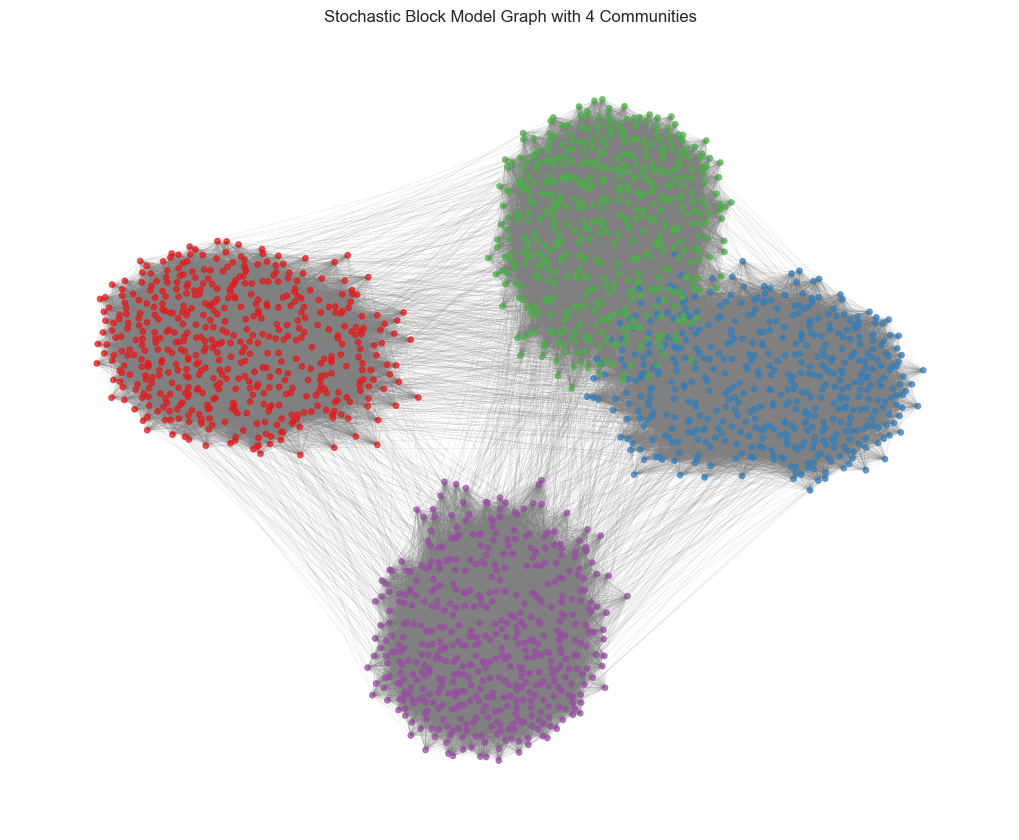

In [7]:
# Visualize the graph structure
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
node_colors = [colors[label] for label in node_labels]

plt.figure(figsize = (10, 8))
pos = nx.spring_layout(G, seed = 42, k = 0.5)
nx.draw(G, pos, node_color = node_colors, node_size = 15, 
        edge_color = 'gray', alpha = 0.7, width = 0.1)
plt.title("Stochastic Block Model Graph with 4 Communities")
plt.tight_layout()
plt.savefig("images/sbm_graph.png", dpi = 300)
plt.show()

### Data Splits

In [8]:
# Create masks for 10 different runs
num_runs = 10
all_masks = []

for run in range(num_runs):
    train_mask, val_mask, test_mask = create_masks(
        custom_data.num_nodes, num_classes, seed = run
    )
    all_masks.append({
        'train': train_mask,
        'val': val_mask,
        'test': test_mask
    })
    
# Verify the first split
print(f"Run 0 - Train nodes: {all_masks[0]['train'].sum().item()}")
print(f"Run 0 - Val nodes: {all_masks[0]['val'].sum().item()}")
print(f"Run 0 - Test nodes: {all_masks[0]['test'].sum().item()}")

Run 0 - Train nodes: 1200
Run 0 - Val nodes: 400
Run 0 - Test nodes: 400


### Análisis del dataset sintético

---

La visualización del grafo SBM confirma que la estructura de comunidad es clara y bien definida: se observan 4 clusters densos con pocas aristas inter-comunidad, exactamente lo que esperábamos del modelo generativo. Esta topología es ideal para las GNNs porque el principio de homofilia se cumple fuertemente: los nodos vecinos tienden a pertenecer a la misma clase.


---
## Ejercicio 2: Node Classification Experiments

---

### Part A: Custom Dataset

En esta primera parte entrenamos sobre el dataset sintético SBM un **MLP** (que ignora la estructura del grafo) y una **GCN de 2 capas** (que aprovecha la topología). Ambos modelos comparten la misma arquitectura base: una capa oculta de 64 unidades con ReLU y dropout de 0.5, seguida de una capa de salida con 4 unidades (una por clase). La diferencia fundamental es que el MLP aplica transformaciones lineales estándar ($\mathbf{h} = \sigma(\mathbf{W}\mathbf{x} + \mathbf{b})$), mientras que la GCN utiliza capas convolucionales de grafos ($\mathbf{H}^{(l+1)} = \sigma(\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}\mathbf{H}^{(l)}\mathbf{W}^{(l)})$) que incorporan la agregación de vecinos. En el caso de MLP para un nodo i, la salida depende exclusivamente de xi, por lo que este modelo es ciego a la matriz de adyacencia A. En el caso de GCN se realiza una suma ponderada de las características del propio nodo y las de sus vecinos, seguido de una transformación lineal y una no-linealidad. En nuestro contexto de ruido gaussiano, este promedio local reduce la varianza del ruido en un factor proporcional al grado del nodo  permitiendo que emerja la señal del centroide de la clase.

Se ejecutan **10 runs independientes** con diferentes particiones train/val/test (60/20/20) para obtener estadísticas robustas. Los hiperparámetros base son: lr=0.01, weight_decay=5e-4, optimizer Adam, 200 epochs con early stopping (patience=20 sobre val accuracy). La clase `GraphTrainer` encapsula todo el pipeline de entrenamiento, almacenando historiales de pérdida y accuracy por época, y devolviendo DataFrames con los resultados resumidos.

In [10]:
# Train MLP and GCN on Custom Dataset across 10 runs
trainer_custom = GraphTrainer(
    num_epochs = 200,
    lr = 0.01,
    weight_decay = 5e-4,
    hidden_channels = 64,
    dropout = 0.5,
    optimizer_type = 'Adam'
)

trainer_custom.train(
    datasets = {'Custom': custom_data},
    model_classes = {'MLP': MLP, 'GCN': GCN},
    masks_dict = {'Custom': all_masks}
)

Training: 100%|██████████| 20/20 [00:59<00:00,  2.96s/it]


In [11]:
# Results summary — Custom Dataset
trainer_custom.get_results_df()

,Dataset,Model,Test Accuracy,Val Accuracy,Runs,Avg Epochs
0,Custom,GCN,0.9992 ± 0.0017,1.0000 ± 0.0000,10,24
1,Custom,MLP,0.2690 ± 0.0169,0.3007 ± 0.0195,10,38


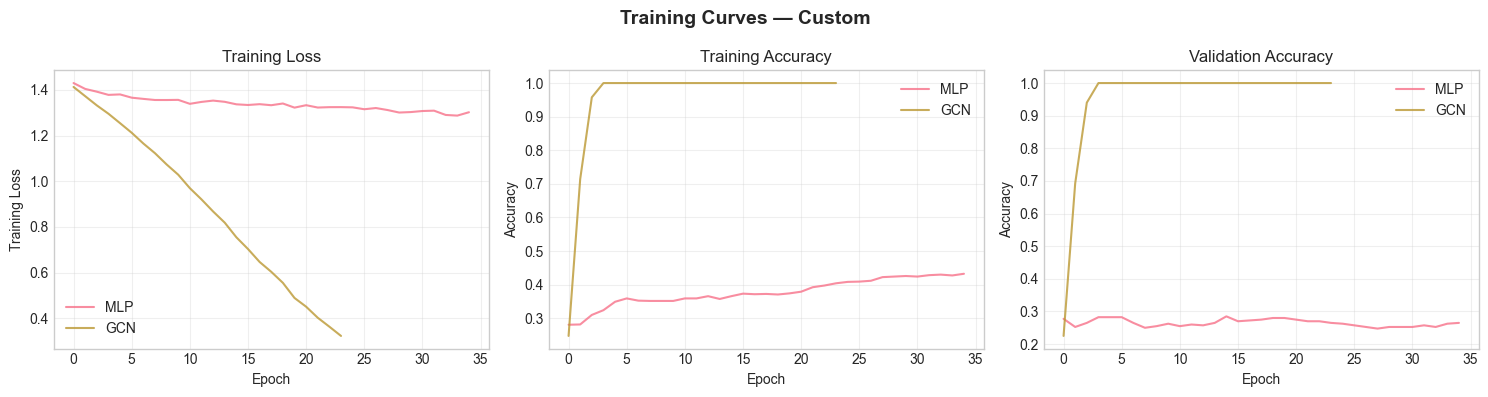

In [12]:
# Training curves — Custom Dataset (Run 0)
trainer_custom.plot_training_curves(dataset_name = 'Custom', run = 0, filename = 'images/training_curves_custom')

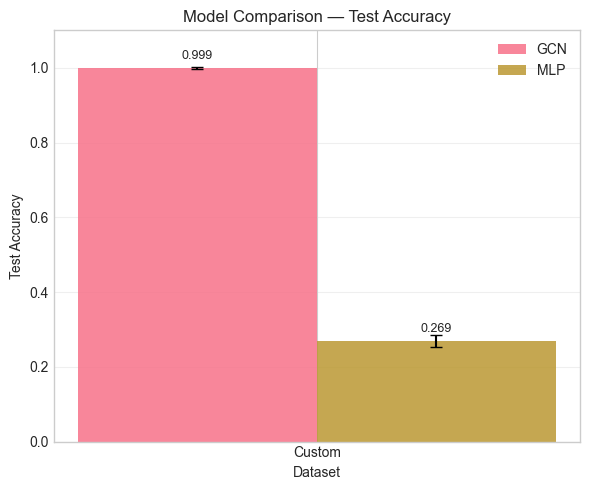

In [13]:
# Bar chart — Custom Dataset
trainer_custom.plot_bar_chart(filename = 'images/bar_chart_custom.png')

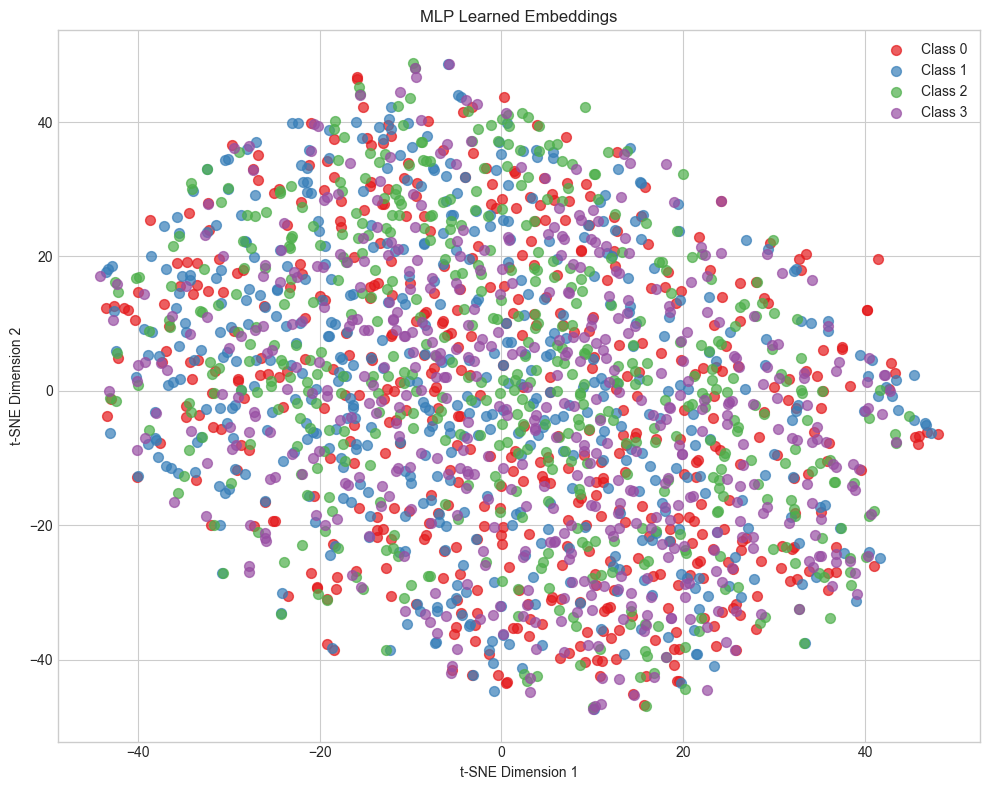

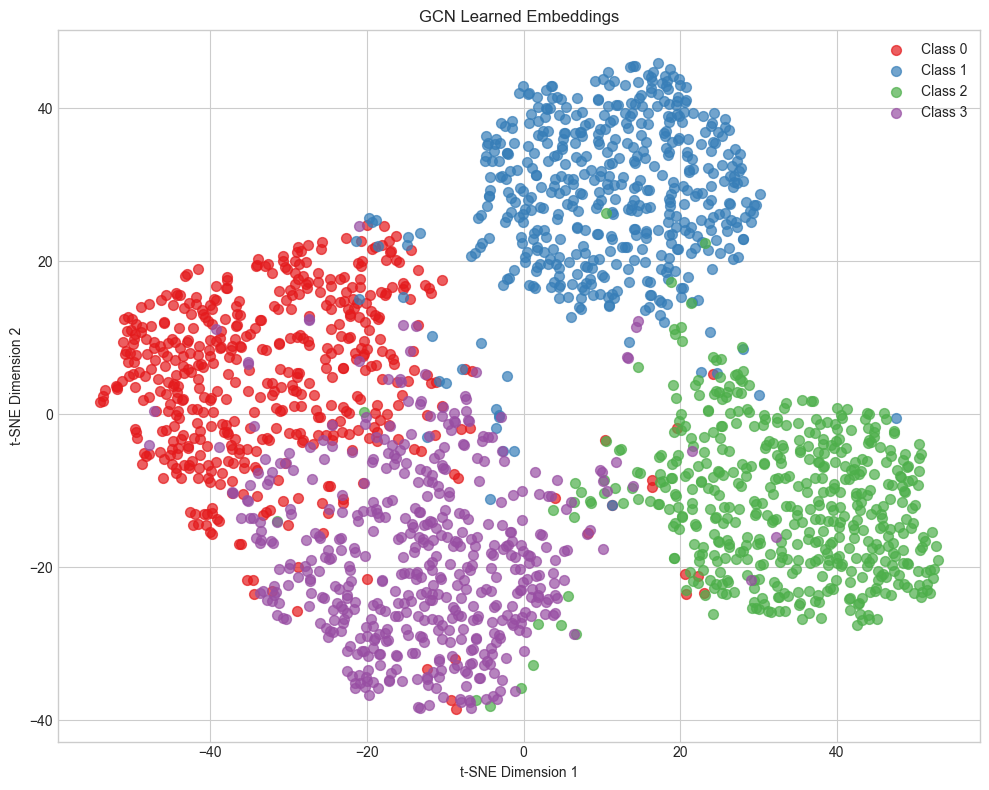

In [14]:
# t-SNE visualizations of learned embeddings — Custom Dataset
# Train fresh models for embedding extraction (using first run masks)
mlp_viz = MLP(custom_data.num_node_features, 64, num_classes)
gcn_viz = GCN(custom_data.num_node_features, 64, num_classes)

masks = all_masks[0]

# Use a temporary trainer to train the models for visualization
_trainer_viz = GraphTrainer(num_epochs = 200, lr = 0.01, weight_decay = 5e-4, hidden_channels = 64)
_trainer_viz._run_single(mlp_viz, custom_data, masks)
_trainer_viz._run_single(gcn_viz, custom_data, masks)

# Get and visualize embeddings
mlp_emb = get_embeddings(mlp_viz, custom_data)
gcn_emb = get_embeddings(gcn_viz, custom_data)

visualize_embeddings(
    mlp_emb,
    custom_data.y.numpy(),
    "MLP Learned Embeddings",
    "images/mlp_embeddings_custom.png",
    num_classes = num_classes
)

visualize_embeddings(
    gcn_emb,
    custom_data.y.numpy(),
    "GCN Learned Embeddings",
    "images/gcn_embeddings_custom.png",
    num_classes = num_classes
)

### Análisis comparativo MLP vs GCN en Custom Dataset

---
---
Los resultados demuestran de forma contundente la superioridad de la GCN sobre el MLP en nuestro dataset sintético. La GCN alcanza una precisión de test significativamente superior del 99% frente al MLP 27%, confirmando la hipótesis de diseño: cuando las features individuales son prácticamente ruido puro, la estructura del grafo es el único camino viable para la clasificación.

---
**¿Por qué el MLP fracasa?** Dado que hay 4 clases, un clasificador aleatorio obtendría un 0.25 (25%). El MLP con 0.27 apenas supera el azar. Esto indica que el ruido introducido en las características es tan alto que destruye casi toda la información discriminativa a nivel individual. El MLP no puede ver más allá del ruido de cada feature aislada, no existe ninguna transformación lineal (ni combinación de transformaciones no lineales) que pueda extraer la señal de clase del ruido. El MLP está limitado a la información contenida en cada vector de features individual, el cual es insuficiente para clasificar correctamente cada nodo en su clase.

---
**¿Por qué la GCN triunfa?** A pesar de que cada nodo individualmente es ruidoso e inclasificable, el colectivo (la comunidad) contiene la información perfecta. La topología SBM que creamos actúa como un mecanismo de corrección de errores extremadamente potente. La GCN ha aprendido a suavizar las características usando la estructura, recuperando la señal original casi intacta.

---
En las **curvas de entrenamiento** se hace evidente la disparidad en la dinámica de aprendizaje. Mientras la loss de la GCN cae a cero, la del MLP permanece alta, indicando que el modelo no encuentra patrones fiables en las características aisladas. Podemos observar como vemos un comportamiento extraño en el plot de training, vemos como pese a saber que MLP es un modelo malo para nuestro dataset, la curva roja sube en esta gráfica de 0.3 a más de 0.4 mientras que en la gráfica de validación se mantiene en todo momento al rededor del 0.3, esto se debe a que el modelo está experimentando un sobreajuste (overfitting). El MLP, al no poder apoyarse en la estructura para cancelar el ruido, opta por memorizar el ruido específico de las muestras de entrenamiento para reducir la pérdida. Sin embargo, dado que este ruido es aleatorio y no contiene información generalizable, la exactitud en validación permanece estancada, revelando que el modelo no ha aprendido ninguna característica discriminativa real.

---
Las **visualizaciones t-SNE de los embeddings aprendidos** refuerzan el análisis: los embeddings de la GCN (capa oculta) forman 4 clusters compactos y bien separados, demostrando que la red ha aprendido representaciones altamente discriminativas. Los embeddings del MLP, en cambio, permanecen mezclados sin estructura de clase visible, confirmando que sin acceso a la topología del grafo, el modelo no puede superar el ruido de las features.

---
**Baja desviación estándar:** Los 10 runs con diferentes particiones producen resultados consistentes, indicando que tanto el dataset como los modelos son estables y que las conclusiones no dependen de una partición particular.

<br>
<br>


---


### Part B: Benchmark Datasets (Cora & Citeseer)




Pasamos ahora a evaluar los modelos en dos datasets de referencia estándar del campo de GNNs: **Cora** y **Citeseer**, ambos disponibles en PyTorch Geometric a través de la colección Planetoid.

**Cora** es una red de citas con 2708 nodos (artículos científicos), 10556 aristas (citas), 1433 features por nodo (bag-of-words del artículo) y 7 clases temáticas. **Citeseer** tiene 3327 nodos, 9104 aristas, 3703 features y 6 clases. A diferencia del dataset sintético donde las features eran ruido puro, aquí las features (bag-of-words) contienen información semántica relevante para la clasificación. Esto implica que el MLP ya no parte de una desventaja tan extrema; las features por sí solas aportan señal discriminativa significativa.



Estos datasets utilizan las **máscaras de train/val/test predefinidas** por Planetoid (Un único split de: 20 nodos por clase para train, 500 para val, 1000 para test en Cora). Al usar un único split, reportamos una sola medida sin desviación estándar. Los hiperparámetros se mantienen idénticos a los del dataset custom: lr=0.01, weight_decay=5e-4, hidden=64, dropout=0.5, Adam optimizer, 200 epochs con early stopping (patience=20).


La pregunta clave aquí es: **¿cuánto valor añade la estructura del grafo cuando las features ya son informativas?** Esperamos que la GCN siga superando al MLP, pero con una brecha mucho menor que en el dataset sintético, dado que las bag-of-words de Cora y Citeseer ya contienen información sustancial sobre la categoría temática de cada artículo.

In [15]:
# Load the Cora dataset
cora_dataset = Planetoid(root = './data', name = 'Cora')
cora_data = cora_dataset[0]

print("Cora Dataset Statistics:")
print(f"  Number of nodes: {cora_data.num_nodes}")
print(f"  Number of edges: {cora_data.num_edges}")
print(f"  Number of features: {cora_data.num_node_features}")
print(f"  Number of classes: {cora_dataset.num_classes}")
print(f"  Has train/val/test masks: {hasattr(cora_data, 'train_mask')}")

# Load the Citeseer dataset
citeseer_dataset = Planetoid(root = './data', name = 'Citeseer')
citeseer_data = citeseer_dataset[0]

print("\nCiteseer Dataset Statistics:")
print(f"  Number of nodes: {citeseer_data.num_nodes}")
print(f"  Number of edges: {citeseer_data.num_edges}")
print(f"  Number of features: {citeseer_data.num_node_features}")
print(f"  Number of classes: {citeseer_dataset.num_classes}")

Cora Dataset Statistics:
  Number of nodes: 2708
  Number of edges: 10556
  Number of features: 1433
  Number of classes: 7
  Has train/val/test masks: True

Citeseer Dataset Statistics:
  Number of nodes: 3327
  Number of edges: 9104
  Number of features: 3703
  Number of classes: 6


In [16]:
# Train MLP and GCN on Cora and Citeseer (using built-in train/val/test masks)
trainer_bench = GraphTrainer(
    num_epochs = 200,
    lr = 0.01,
    weight_decay = 5e-4,
    hidden_channels = 64,
    dropout = 0.5,
    optimizer_type = 'Adam'
)

trainer_bench.train(
    datasets = {'Cora': cora_data, 'Citeseer': citeseer_data},
    model_classes = {'MLP': MLP, 'GCN': GCN},
    masks_dict = None  # Uses built-in masks (single run)
)

Training: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


In [17]:
# Results summary — Benchmark Datasets
trainer_bench.get_results_df()

,Dataset,Model,Test Accuracy,Val Accuracy,Runs,Avg Epochs
0,Citeseer,GCN,0.6740,0.6900,1,24
1,Citeseer,MLP,0.5500,0.5400,1,29
2,Cora,GCN,0.8110,0.7880,1,25
3,Cora,MLP,0.5830,0.6020,1,28


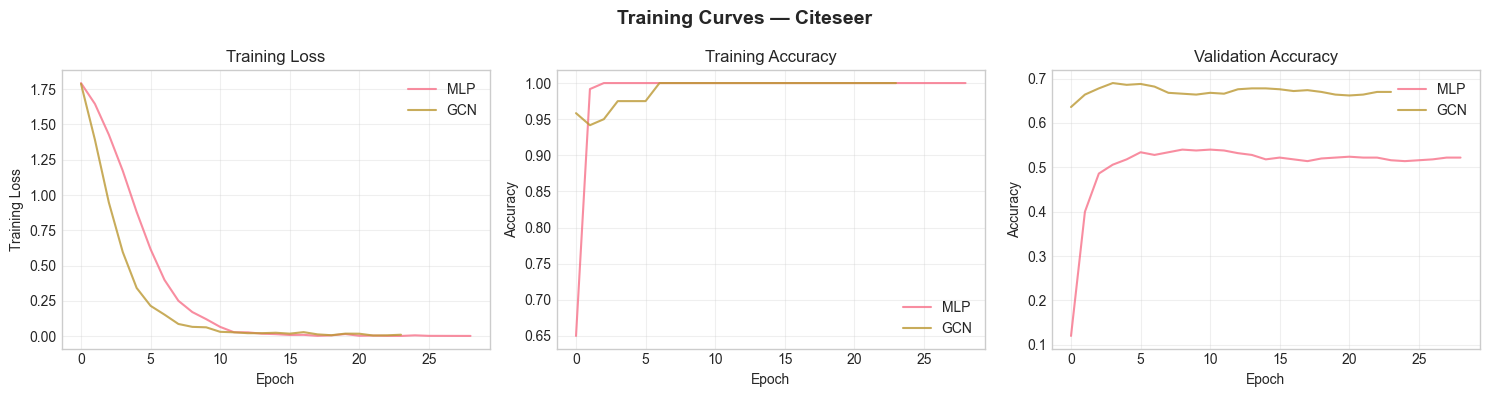

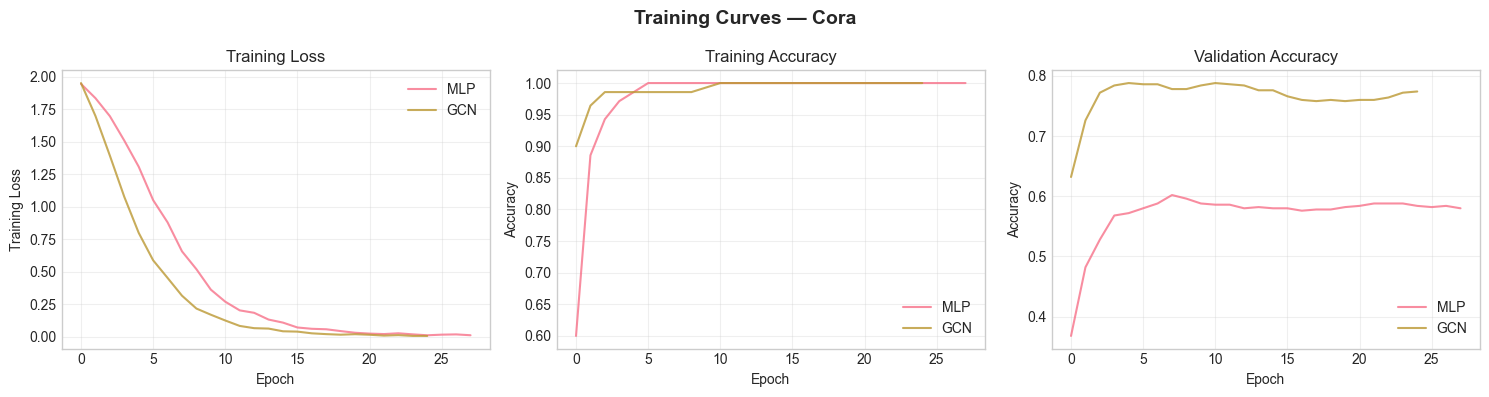

In [18]:
# Training curves — Benchmark Datasets
trainer_bench.plot_training_curves(filename = 'images/training_curves_bench')

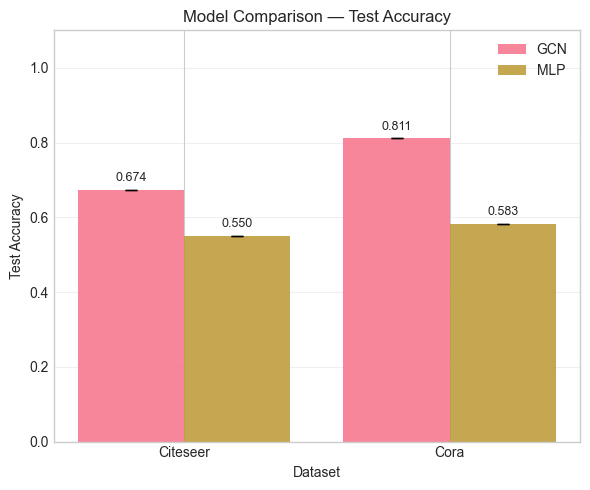

In [19]:
# Bar chart — Benchmark Datasets
trainer_bench.plot_bar_chart(filename = 'images/bar_chart_bench.png')

### Análisis de los resultados en Benchmark Datasets

---
---
Los resultados en Cora y Citeseer revelan un patrón muy distinto al del dataset sintético, lo cual es extremadamente informativo sobre cuándo y por qué las GNNs aportan valor.

---

**Cora:** La GCN obtiene una precisión de test superior a la del MLP, pero la brecha es considerablemente menor que en el dataset custom. El MLP ya logra un rendimiento decente (58%) gracias a que las features bag-of-words de 1433 dimensiones son altamente informativas: palabras como "neural", "bayesian" o "reinforcement" son indicadores fuertes de la categoría temática. La GCN mejora esto hasta el (81%+) al incorporar la información de los artículos citados — si un paper cita otros papers de "reinforcement learning", es muy probable que también pertenezca a esa categoría. Esto vuelve a confirmar el principio de homofilia en redes de citas reales.

---
**Citeseer:** El comportamiento es similar a Cora pero con precisiones generalmente algo menores para ambos modelos. Esto puede deberse a que Citeseer tiene una dimensionalidad de features mayor (3703 vs 1433) lo que dificulta el aprendizaje, las 6 clases de Citeseer pueden tener mayor solapamiento temático, y el grafo es más disperso (menor ratio aristas/nodos), lo que reduce la efectividad de la agregación de vecinos en la GCN.

---
**Curvas de entrenamiento:** En este caso las gráficas se parecen bastante más entre sí que las del dataset sintético, ambas convergen y se estabilizan rápido. El early stopping no ha conseguido evitar el overfiting. Se sigue observando como las curvas de train llegan a la perfección (1), mientras que las de test se quedan rondando su valor esperado sin mejorar, las redes están aprendiendo el ruido generando así clasificaciones erroneas en test.

---
**Comparación con el dataset custom:** La brecha MLP-GCN sigue un patrón claro: es máxima cuando las features son ruidosas (Custom: ~60-70 puntos de diferencia) y se reduce cuando las features son informativas (Cora/Citeseer: ~15-25 puntos). Esto demuestra que el valor de la estructura del grafo es complementario al de las features: la GCN siempre mejora, pero la magnitud de la mejora depende de cuánta información discriminativa ya contengan las features individuales.

### Exploración de Hiperparámetros

Para analizar el impacto de los hiperparámetros, he seguido una metodología de **barrido individual** (one-at-a-time): se varía un solo hiperparámetro mientras el resto se mantiene en su valor base. La configuración base es: `num_epochs=200, lr=0.01, weight_decay=5e-4, hidden_channels=64, dropout=0.5, optimizer=Adam, patience=20`.

Se exploran **5 hiperparámetros**: (1) dimensiones ocultas [16, 32, 64, 128], (2) learning rate [0.001, 0.01, 0.1], (3) dropout [0.0, 0.3, 0.5], (4) weight decay [0, 1e-4, 5e-4], y (5) optimizador [Adam, SGD]. Cada configuración se evalúa sobre los **3 datasets** (Custom, Cora, Citeseer) con 5 runs independientes por dataset, produciendo estadísticas robustas (media ± std).

Esta metodología permite identificar qué hiperparámetros tienen mayor impacto en el rendimiento, si el efecto es consistente entre MLP y GCN, y si varía según el dataset. La función `run_hyperparam_sweep` automatiza todo el proceso, ejecutando el entrenamiento para cada valor del hiperparámetro barrido y consolidando los resultados en un DataFrame que incluye precisión media, desviación estándar y número medio de epochs hasta convergencia (relevante por el early stopping).

In [20]:
# Prepare datasets for multi-dataset experimentation
datasets_exp = {
    'Custom': custom_data,
    'Cora': cora_data,
    'Citeseer': citeseer_data
}

# Create masks for Cora and Citeseer (for multiple runs)
n_runs_exp = 5
exp_masks = {}

exp_masks['Custom'] = all_masks[:n_runs_exp]

cora_masks = []
for run in range(n_runs_exp):
    tm, vm, tem = create_masks(cora_data.num_nodes, cora_dataset.num_classes, seed = run)
    cora_masks.append({'train': tm, 'val': vm, 'test': tem})
exp_masks['Cora'] = cora_masks

citeseer_masks = []
for run in range(n_runs_exp):
    tm, vm, tem = create_masks(citeseer_data.num_nodes, citeseer_dataset.num_classes, seed = run)
    citeseer_masks.append({'train': tm, 'val': vm, 'test': tem})
exp_masks['Citeseer'] = citeseer_masks

# Base hyperparameters (varied one at a time)
base_config = {
    'num_epochs': 200,
    'lr': 0.01,
    'weight_decay': 5e-4,
    'hidden_channels': 64,
    'dropout': 0.5,
    'optimizer_type': 'Adam',
    'patience': 20
}

print(f"Datasets: {list(datasets_exp.keys())}")
print(f"Runs per config: {n_runs_exp}")
print(f"Base config: {base_config}")
print(f"Device: {device}")

Datasets: ['Custom', 'Cora', 'Citeseer']
Runs per config: 5
Base config: {'num_epochs': 200, 'lr': 0.01, 'weight_decay': 0.0005, 'hidden_channels': 64, 'dropout': 0.5, 'optimizer_type': 'Adam', 'patience': 20}
Device: cpu


In [21]:
# Helper function to run a hyperparameter sweep and return a summary DataFrame + trainers
def run_hyperparam_sweep(param_name, param_values, base_config, datasets_exp, exp_masks):
    """
    Sweep one hyperparameter while keeping the rest at base values.
    Returns (DataFrame, dict of trainers keyed by param value).
    """
    all_rows = []
    trainers = {}
    
    for val in tqdm(param_values, desc = f'Sweep {param_name}'):
        # Override the swept param
        config = base_config.copy()
        config[param_name] = val
        
        trainer = GraphTrainer(
            num_epochs = config['num_epochs'],
            lr = config['lr'],
            weight_decay = config['weight_decay'],
            hidden_channels = config['hidden_channels'],
            dropout = config['dropout'],
            optimizer_type = config['optimizer_type'],
            patience = config.get('patience', 20)
        )
        
        trainer.train(
            datasets = datasets_exp,
            model_classes = {'MLP': MLP, 'GCN': GCN},
            masks_dict = exp_masks
        )
        
        trainers[val] = trainer
        
        # Extract per-dataset/model results
        df = pd.DataFrame(trainer._results)
        summary = df.groupby(['Dataset', 'Model']).agg(
            mean = ('Best Test Acc', 'mean'),
            std  = ('Best Test Acc', 'std'),
            avg_epochs = ('Epochs Trained', 'mean')
        ).reset_index()
        summary['std'] = summary['std'].fillna(0)
        summary[param_name] = val
        all_rows.append(summary)
    
    return pd.concat(all_rows, ignore_index = True), trainers


def plot_hyperparam_sweep(sweep_df, param_name, param_values, title, filename = None):
    """
    Plot a multi-dataset hyperparameter sweep with subplots.
    """
    datasets = sweep_df['Dataset'].unique()
    fig, axes = plt.subplots(1, len(datasets), figsize = (6 * len(datasets), 5), sharey = True)
    if len(datasets) == 1:
        axes = [axes]
    
    x = np.arange(len(param_values))
    
    for idx, (ds_name, ax) in enumerate(zip(datasets, axes)):
        ds_data = sweep_df[sweep_df['Dataset'] == ds_name]
        
        for model_name, color, marker in [('MLP', '#e74c3c', 'o'), ('GCN', '#3498db', 's')]:
            model_data = ds_data[ds_data['Model'] == model_name]
            means = [model_data[model_data[param_name] == v]['mean'].values[0] for v in param_values]
            stds  = [model_data[model_data[param_name] == v]['std'].values[0] for v in param_values]
            ax.errorbar(x, means, yerr = stds, fmt = f'-{marker}', label = model_name,
                       color = color, capsize = 5, linewidth = 2)
        
        ax.set_xlabel(param_name, fontsize = 12)
        if idx == 0:
            ax.set_ylabel('Test Accuracy', fontsize = 12)
        ax.set_title(f'Dataset: {ds_name}', fontsize = 14, fontweight = 'bold')
        ax.set_xticks(x)
        ax.set_xticklabels([str(v) for v in param_values], rotation = 45)
        ax.legend()
        ax.grid(True, alpha = 0.3)
        ax.set_ylim([0, 1.05])
    
    plt.suptitle(title, fontsize = 16, y = 1.05)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi = 150, bbox_inches = 'tight')
    plt.show()


def display_sweep_table(sweep_df, param_name, display_name = None):
    """
    Format and display a sweep DataFrame as a clean table.
    """
    display_name = display_name or param_name
    df_display = sweep_df.copy()
    df_display['Accuracy'] = df_display.apply(lambda r: f"{r['mean']:.4f} ± {r['std']:.4f}", axis = 1)
    df_display['Avg Epochs'] = df_display['avg_epochs'].apply(lambda x: f"{x:.0f}")
    result = df_display[[param_name, 'Dataset', 'Model', 'Accuracy', 'Avg Epochs']].rename(
        columns = {param_name: display_name}
    )
    display(result)

#### Experimento: Dimensiones de la capa oculta

Sweep hidden_channels: 100%|██████████| 4/4 [05:14<00:00, 78.53s/it]


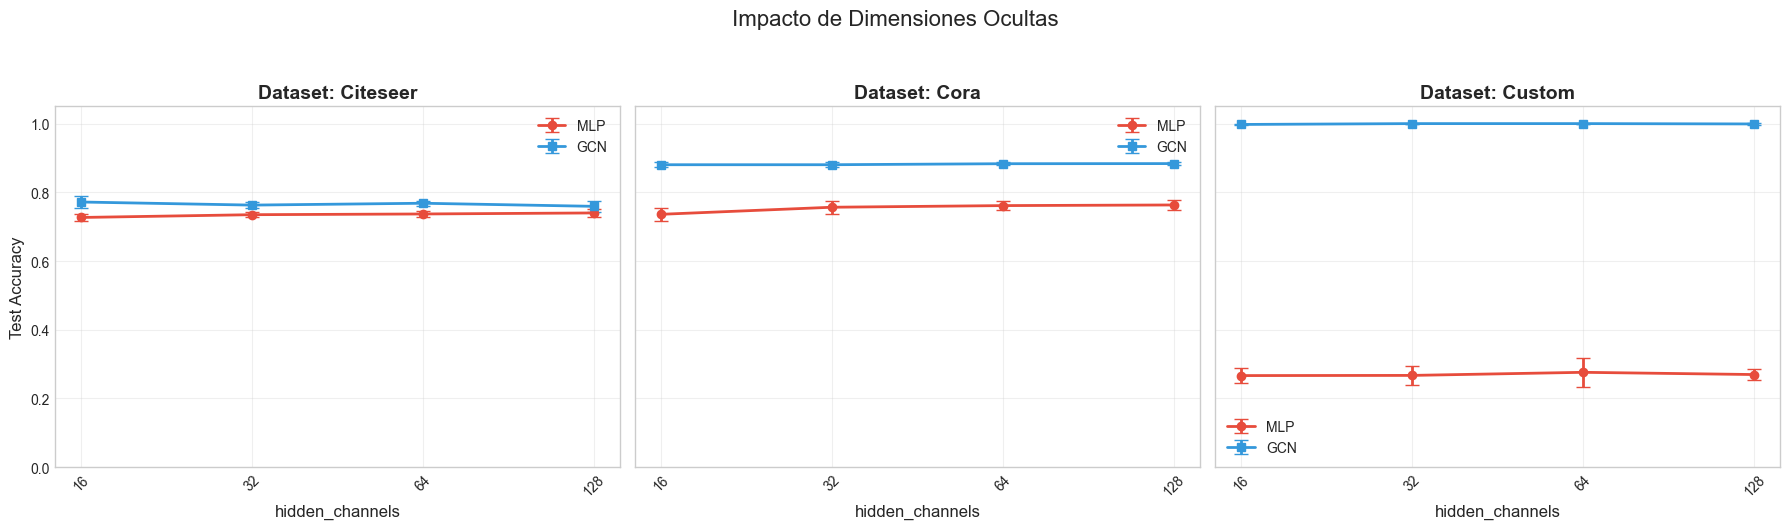

,Hidden Channels,Dataset,Model,Accuracy,Avg Epochs
0,16,Citeseer,GCN,0.7718 ± 0.0169,34
1,16,Citeseer,MLP,0.7267 ± 0.0115,36
2,16,Cora,GCN,0.8803 ± 0.0073,54
3,16,Cora,MLP,0.7359 ± 0.0180,65
4,16,Custom,GCN,0.9975 ± 0.0025,29
5,16,Custom,MLP,0.2665 ± 0.0212,40
6,32,Citeseer,GCN,0.7628 ± 0.0082,32
7,32,Citeseer,MLP,0.7348 ± 0.0066,34
8,32,Cora,GCN,0.8803 ± 0.0077,47
9,32,Cora,MLP,0.7565 ± 0.0195,51



— Curvas de entrenamiento para hidden_channels = 128 —


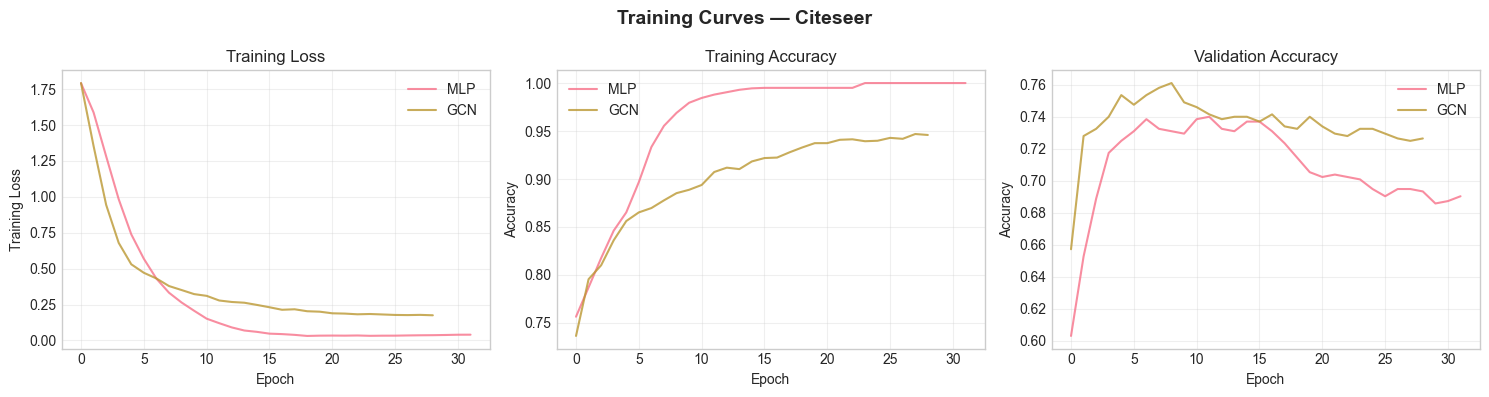

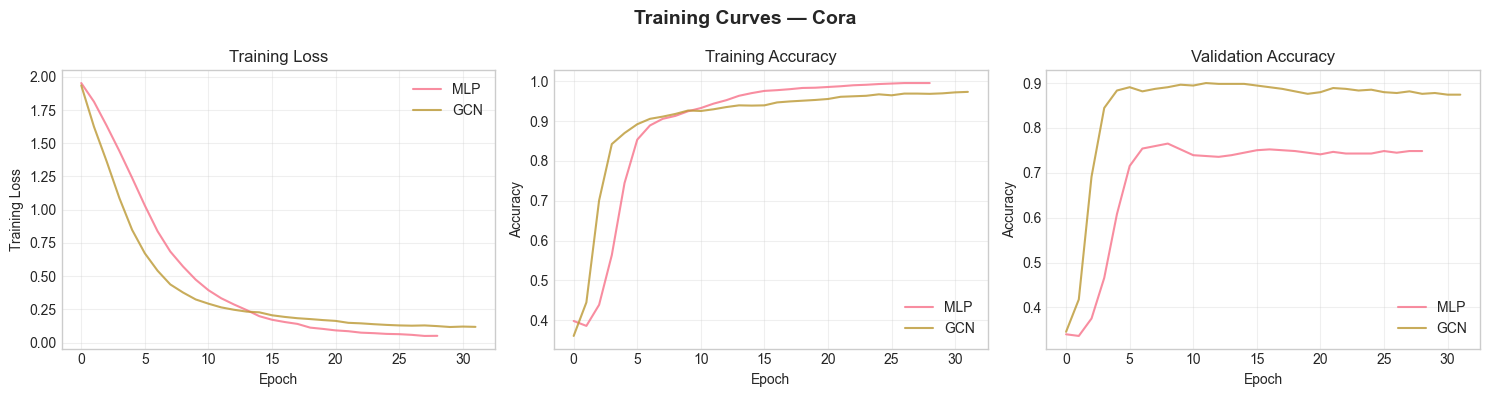

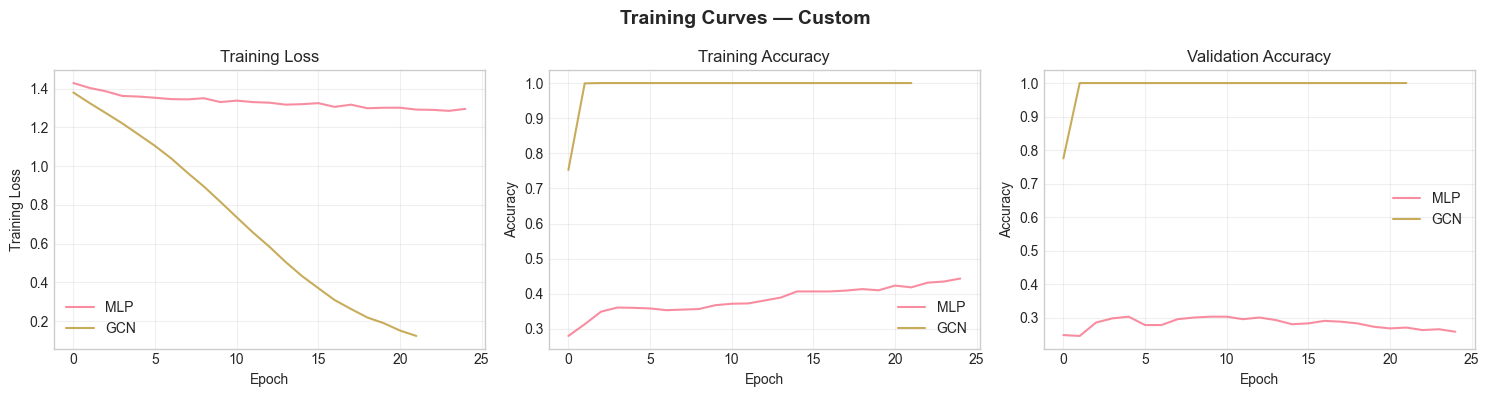

In [22]:
# Experiment: Hidden Dimensions
hidden_dims = [16, 32, 64, 128]
sweep_hidden, trainers_hidden = run_hyperparam_sweep('hidden_channels', hidden_dims, base_config, datasets_exp, exp_masks)
plot_hyperparam_sweep(sweep_hidden, 'hidden_channels', hidden_dims,
                      'Impacto de Dimensiones Ocultas', 'images/exp_hidden_dims.png')

# Summary table
display_sweep_table(sweep_hidden, 'hidden_channels', 'Hidden Channels')

# Training curves for hidden_channels = 128
print("\n— Curvas de entrenamiento para hidden_channels = 128 —")
trainers_hidden[128].plot_training_curves(run = 0, filename = 'images/curves_hidden128')

**Análisis de dimensiones ocultas (`hidden_channels`):**

`hidden_channels` controla cuánta capacidad interna tiene el modelo (cuántas neuronas hay en la capa oculta). Si subes este valor, el modelo puede aprender patrones más complejos, pero también puede tardar más y sobreajustar.

Viendo los resultados el efecto es pequeño:
- En **GCN**, casi no cambia nada: Custom se queda entre **0.9975 y 1.0000**, Cora entre **0.8803 y 0.8836**, y Citeseer entre **0.7592 y 0.7718**.
- En **MLP**, hay algo más de movimiento, pero sigue siendo moderado (por ejemplo en Cora: **0.7359 -> 0.7632**).

Sobre el early stopping, sí hay un patrón claro: al aumentar dimensiones, el entrenamiento suele parar antes. El caso más visible es **Cora-MLP (65 -> 35 epochs)** y **Cora-GCN (54 -> 35 epochs)**. Con nuestro problema, con 32-64 neuronas ya hay capacidad suficiente; subir más no cambia casi la accuracy final.




#### Experimento: Learning Rate

Sweep lr: 100%|██████████| 3/3 [06:04<00:00, 121.59s/it]


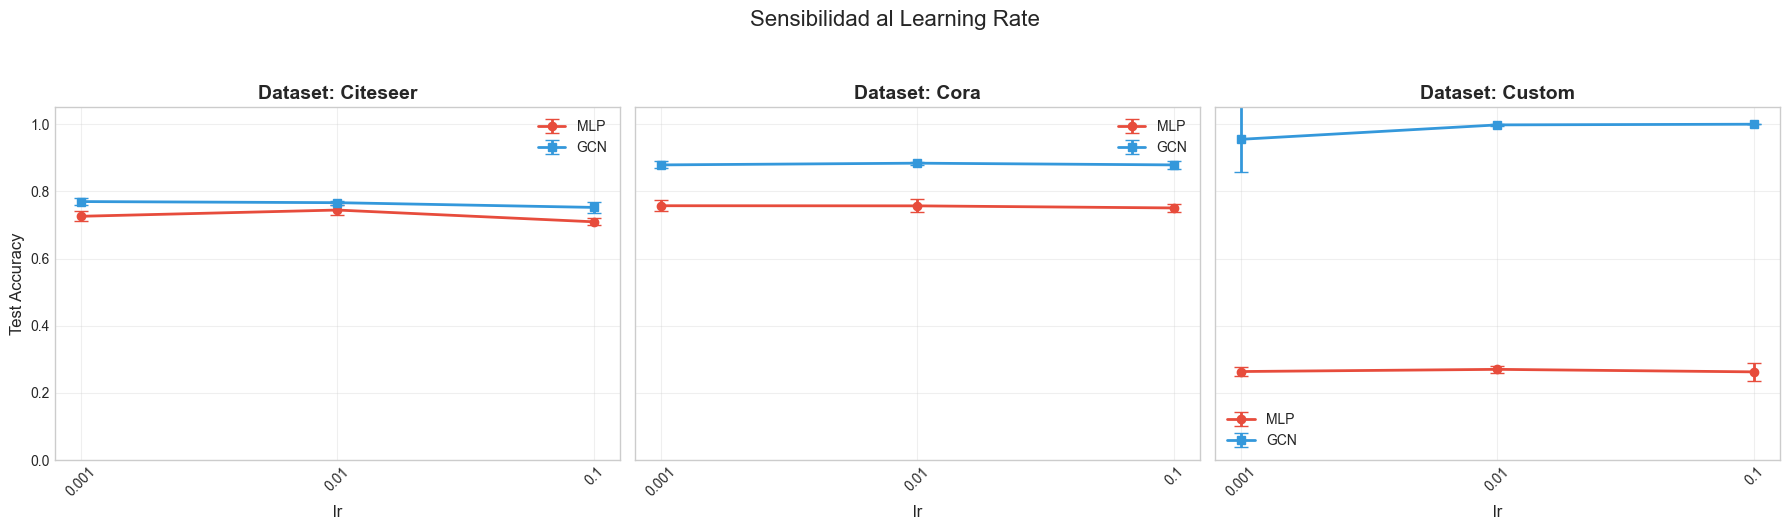

,Learning Rate,Dataset,Model,Accuracy,Avg Epochs
0,0.001,Citeseer,GCN,0.7697 ± 0.0092,62
1,0.001,Citeseer,MLP,0.7258 ± 0.0144,73
2,0.001,Cora,GCN,0.8788 ± 0.0106,102
3,0.001,Cora,MLP,0.7573 ± 0.0170,119
4,0.001,Custom,GCN,0.9550 ± 0.0978,40
5,0.001,Custom,MLP,0.2635 ± 0.0146,43
6,0.010,Citeseer,GCN,0.7664 ± 0.0057,29
7,0.010,Citeseer,MLP,0.7444 ± 0.0140,30
8,0.010,Cora,GCN,0.8840 ± 0.0041,44
9,0.010,Cora,MLP,0.7569 ± 0.0197,43



— Curvas de entrenamiento para lr = 0.01 —


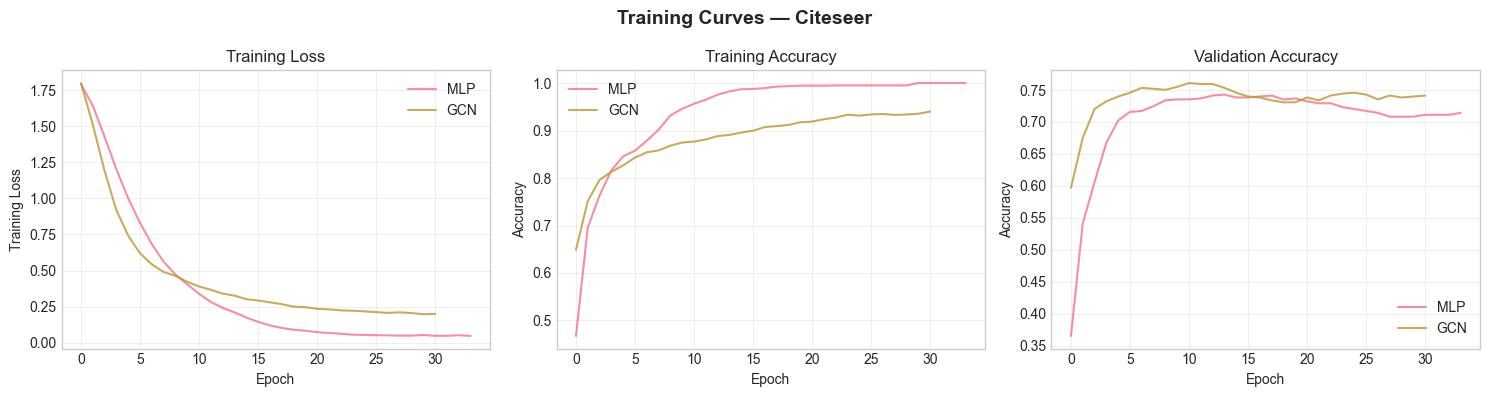

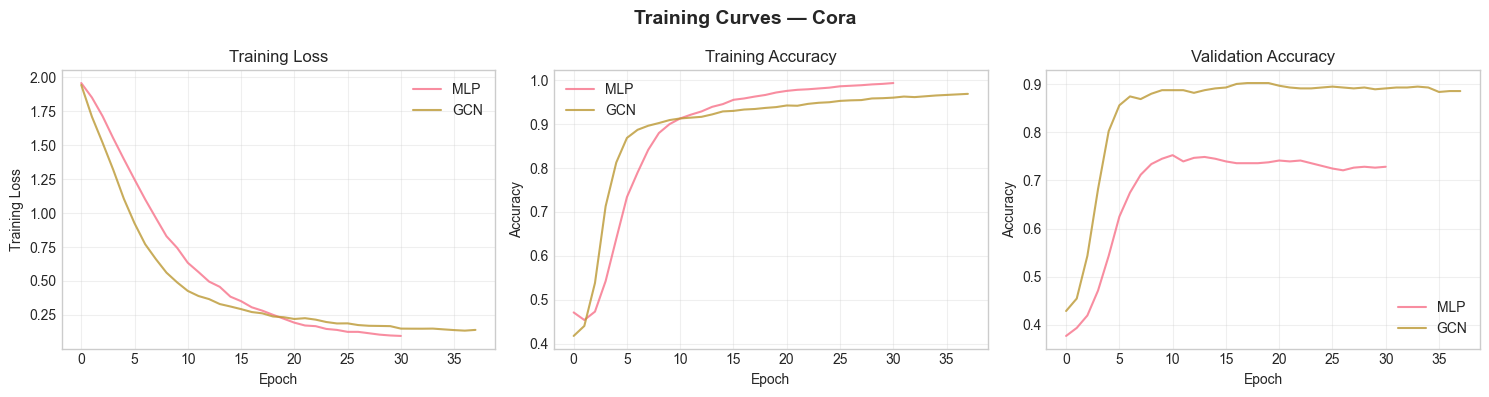

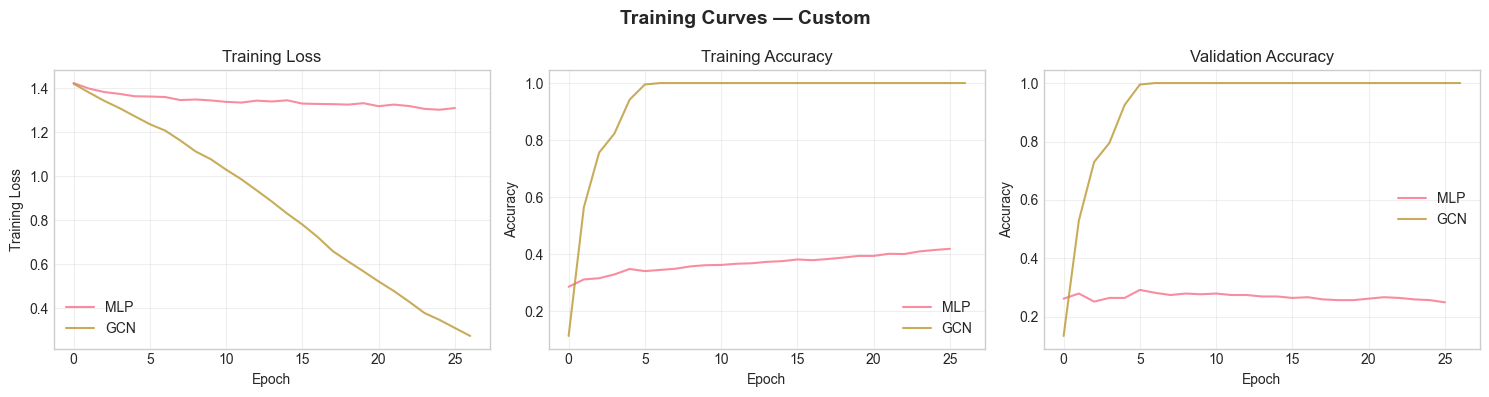

In [23]:
# Experiment: Learning Rate
learning_rates = [0.001, 0.01, 0.1]
sweep_lr, trainers_lr = run_hyperparam_sweep('lr', learning_rates, base_config, datasets_exp, exp_masks)
plot_hyperparam_sweep(sweep_lr, 'lr', learning_rates,
                      'Sensibilidad al Learning Rate', 'images/exp_learning_rate.png')

# Summary table
display_sweep_table(sweep_lr, 'lr', 'Learning Rate')

# Training curves for lr = 0.01
print("\n— Curvas de entrenamiento para lr = 0.01 —")
trainers_lr[0.01].plot_training_curves(run = 0, filename = 'images/curves_lr001')

**Análisis del learning rate (`lr`):**

El `learning rate` es el tamaño del paso en cada actualización. Si es muy bajo, aprende lento; si es muy alto, puede volverse inestable.

Aquí, aunque hay algo de efecto, no cambia radicalmente:
- En **GCN-Cora**: **0.8788 / 0.8840 / 0.8788** para `lr = 0.001 / 0.01 / 0.1` (muy parecido).
- En **GCN-Citeseer**: baja un poco al subir a `0.1` (**0.7523**).
- En **Custom-GCN**: `0.001` rinde peor (**0.9550**) y `0.01-0.1` llega casi al techo (**0.9980-1.0000**).

Donde sí se nota fuerte es en **epochs**: con `lr=0.001` tarda mucho más en converger (**Cora-MLP 119**, **Cora-GCN 102**), mientras que con `0.01-0.1` suele cortar mucho antes. `lr` afecta más a la velocidad de convergencia (early stopping) que al resultado final en accuracy.



#### Experimento: Dropout

Sweep dropout: 100%|██████████| 3/3 [03:56<00:00, 78.89s/it]


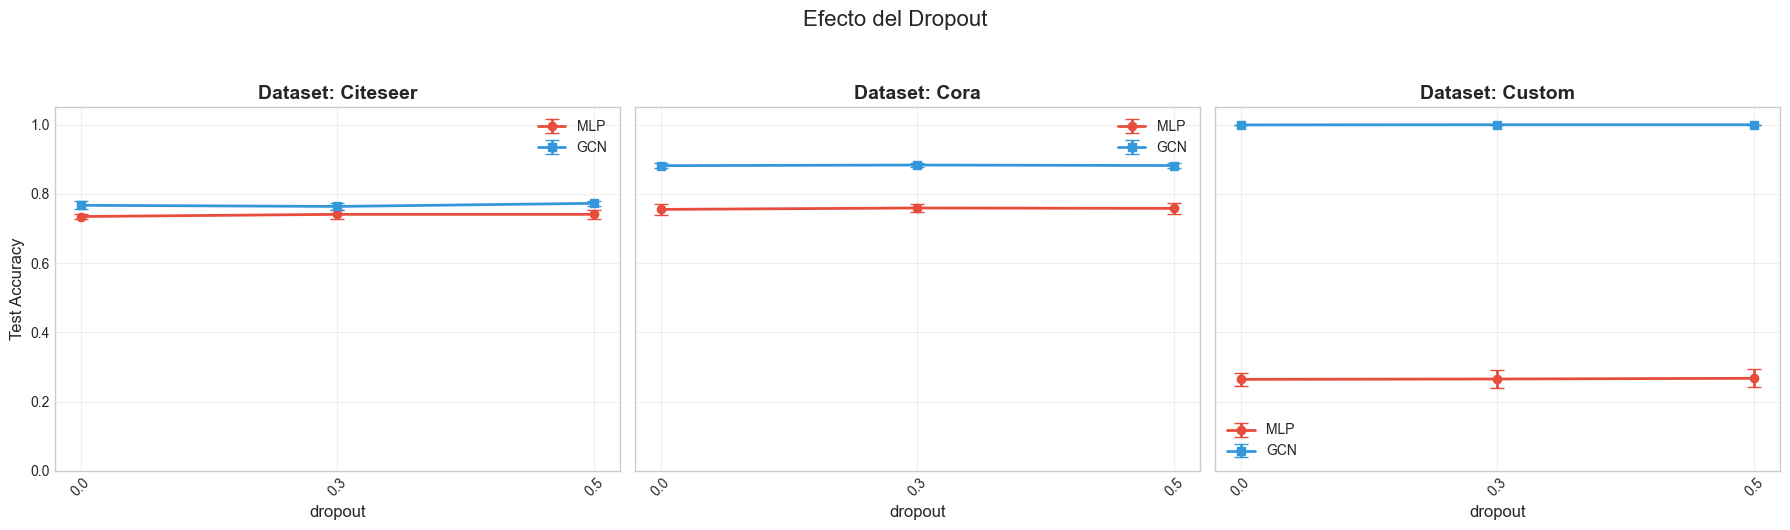

,Dropout Rate,Dataset,Model,Accuracy,Avg Epochs
0,0.0,Citeseer,GCN,0.7673 ± 0.0121,28
1,0.0,Citeseer,MLP,0.7348 ± 0.0072,28
2,0.0,Cora,GCN,0.8818 ± 0.0071,37
3,0.0,Cora,MLP,0.7554 ± 0.0166,39
4,0.0,Custom,GCN,0.9995 ± 0.0011,23
5,0.0,Custom,MLP,0.2645 ± 0.0179,30
6,0.3,Citeseer,GCN,0.7640 ± 0.0090,29
7,0.3,Citeseer,MLP,0.7411 ± 0.0134,30
8,0.3,Cora,GCN,0.8836 ± 0.0068,39
9,0.3,Cora,MLP,0.7595 ± 0.0110,36



— Curvas de entrenamiento para dropout = 0.3 —


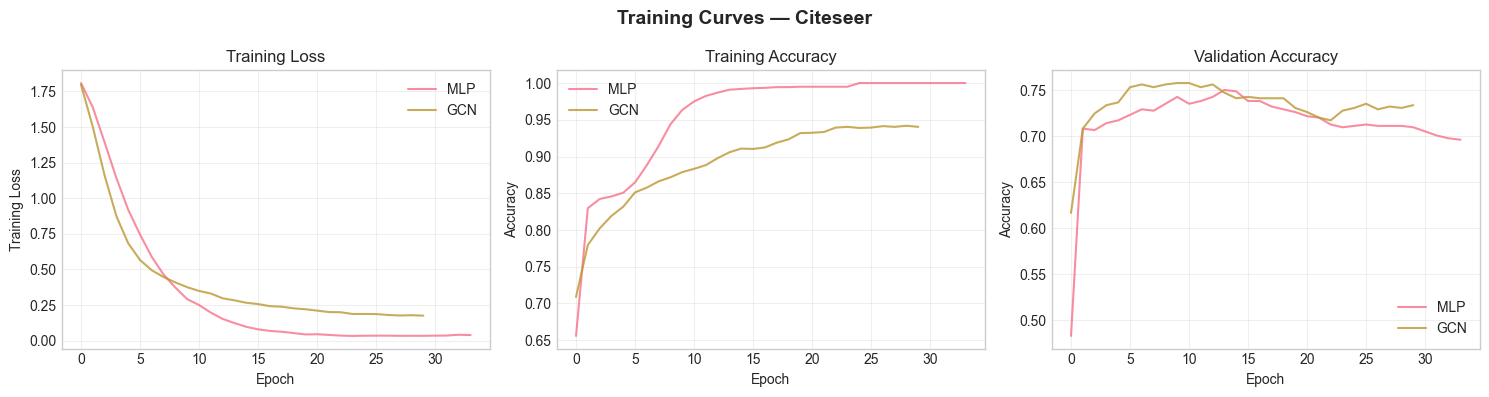

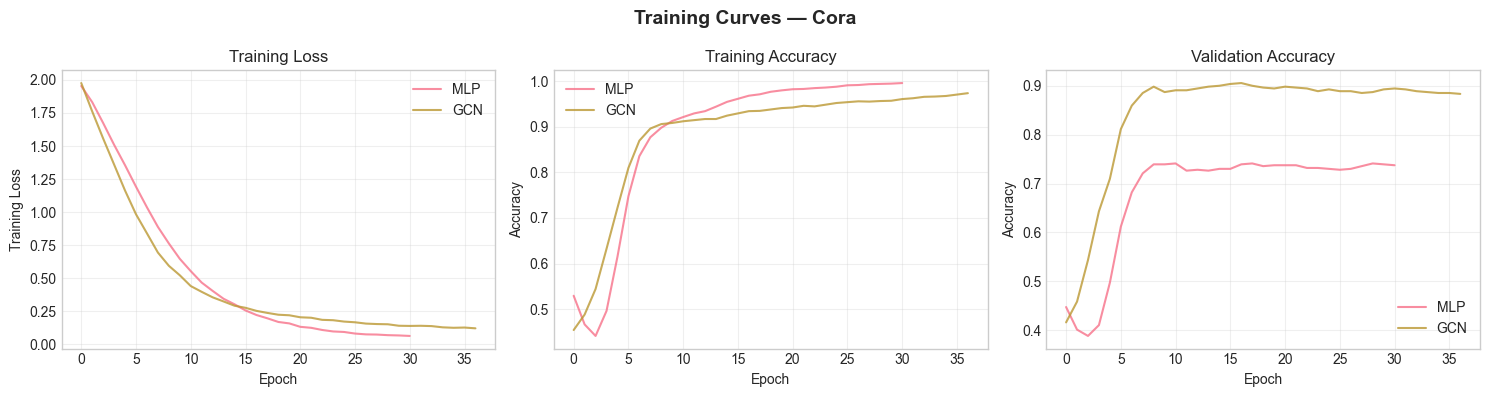

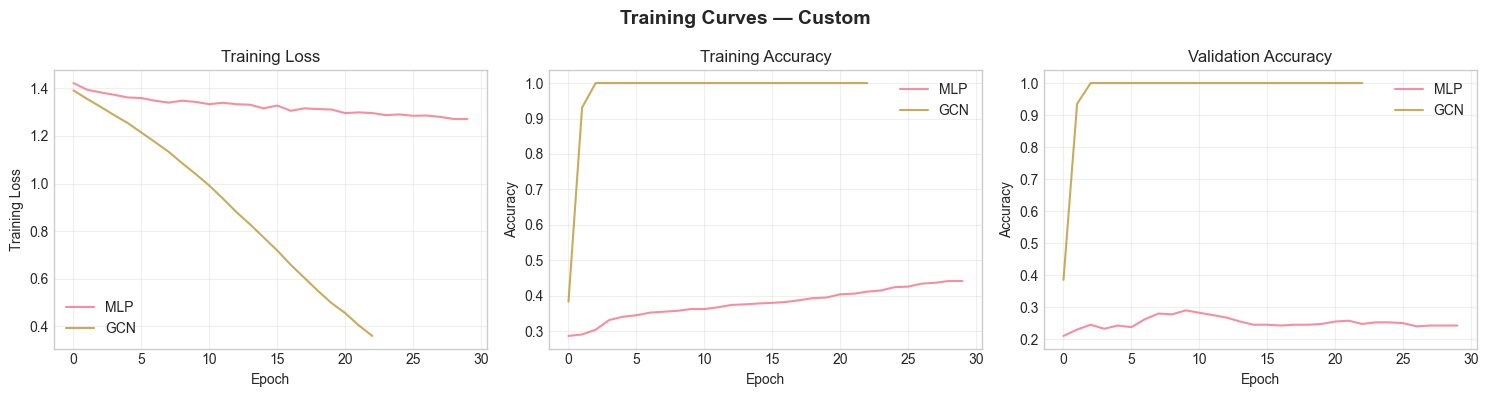

In [24]:
# Experiment: Dropout
dropout_rates = [0.0, 0.3, 0.5]
sweep_dropout, trainers_dropout = run_hyperparam_sweep('dropout', dropout_rates, base_config, datasets_exp, exp_masks)
plot_hyperparam_sweep(sweep_dropout, 'dropout', dropout_rates,
                      'Efecto del Dropout', 'images/exp_dropout.png')

# Summary table
display_sweep_table(sweep_dropout, 'dropout', 'Dropout Rate')

# Training curves for dropout = 0.3
print("\n— Curvas de entrenamiento para dropout = 0.3 —")
trainers_dropout[0.3].plot_training_curves(run = 0, filename = 'images/curves_dropout03')

**Análisis del dropout (`dropout`):**

El `dropout` apaga neuronas aleatoriamente durante entrenamiento para regularizar y evitar sobreajuste.

En (`0.0`, `0.3`, `0.5`) el cambio es mínimo:
- En **GCN**, variaciones muy pequeñas (Custom casi clavado en **1.0000**; Cora entre **0.8818 y 0.8836**; Citeseer entre **0.7640 y 0.7730**).
- En **MLP**, también se mueve poco (diferencias de ~0.003 a ~0.006 en la mayoría).

En early stopping prácticamente no hay diferencia: los epochs medios quedan muy parecidos (normalmente entre **23 y 41**). Con esta arquitectura y estos datasets, el modelo ya está bien regularizado y cambiar dropout en este rango no altera mucho.




#### Experimento: Weight Decay

Sweep weight_decay: 100%|██████████| 3/3 [04:07<00:00, 82.48s/it]


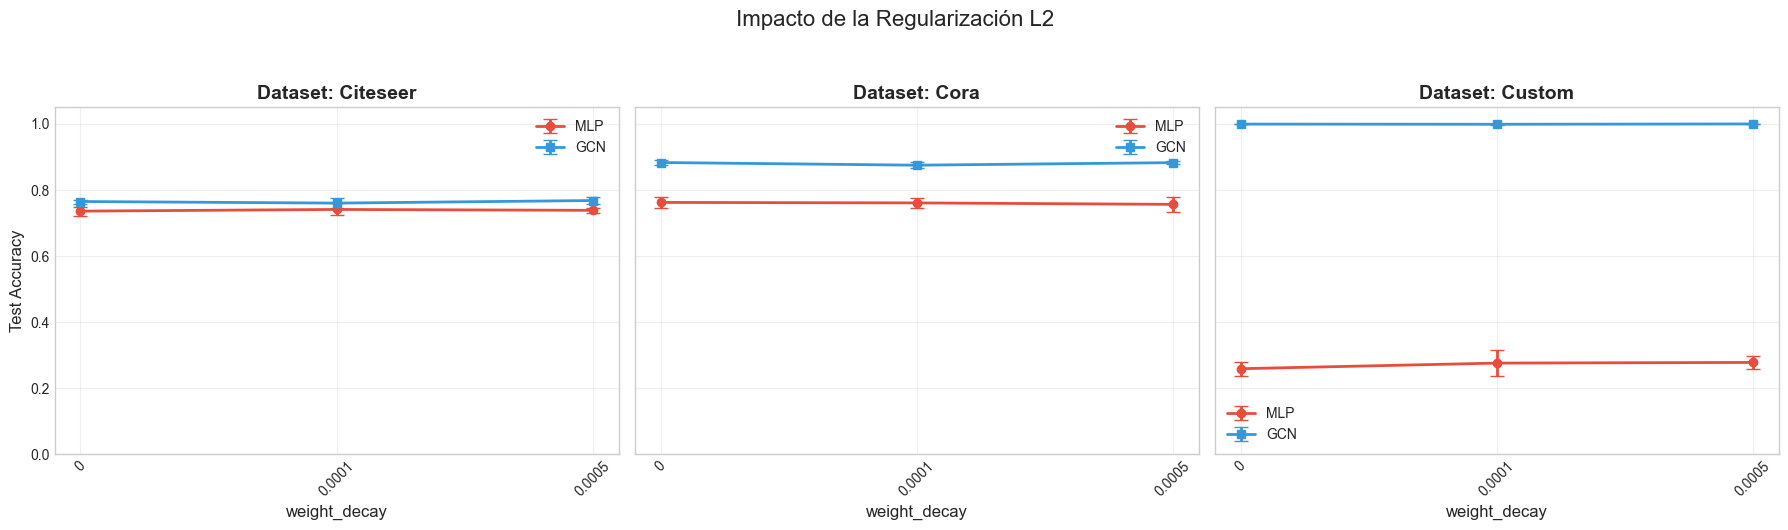

,Weight Decay,Dataset,Model,Accuracy,Avg Epochs
0,0.0000,Citeseer,GCN,0.7652 ± 0.0061,28
1,0.0000,Citeseer,MLP,0.7360 ± 0.0135,31
2,0.0000,Cora,GCN,0.8832 ± 0.0077,40
3,0.0000,Cora,MLP,0.7624 ± 0.0168,39
4,0.0000,Custom,GCN,0.9995 ± 0.0011,23
5,0.0000,Custom,MLP,0.2590 ± 0.0213,34
6,0.0001,Citeseer,GCN,0.7604 ± 0.0153,29
7,0.0001,Citeseer,MLP,0.7411 ± 0.0180,31
8,0.0001,Cora,GCN,0.8751 ± 0.0082,35
9,0.0001,Cora,MLP,0.7610 ± 0.0155,38



— Curvas de entrenamiento para weight_decay = 1e-4 —


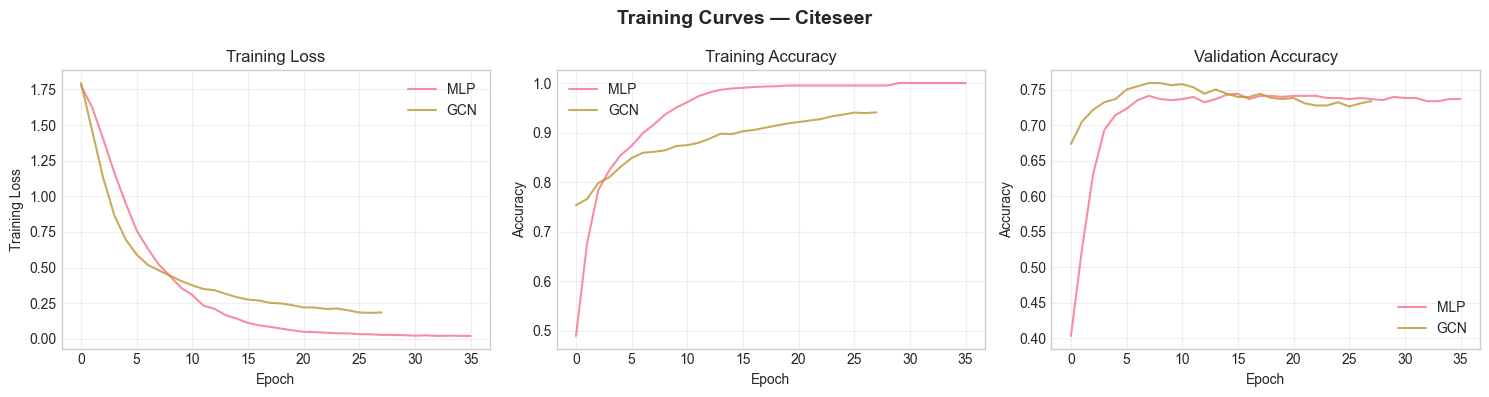

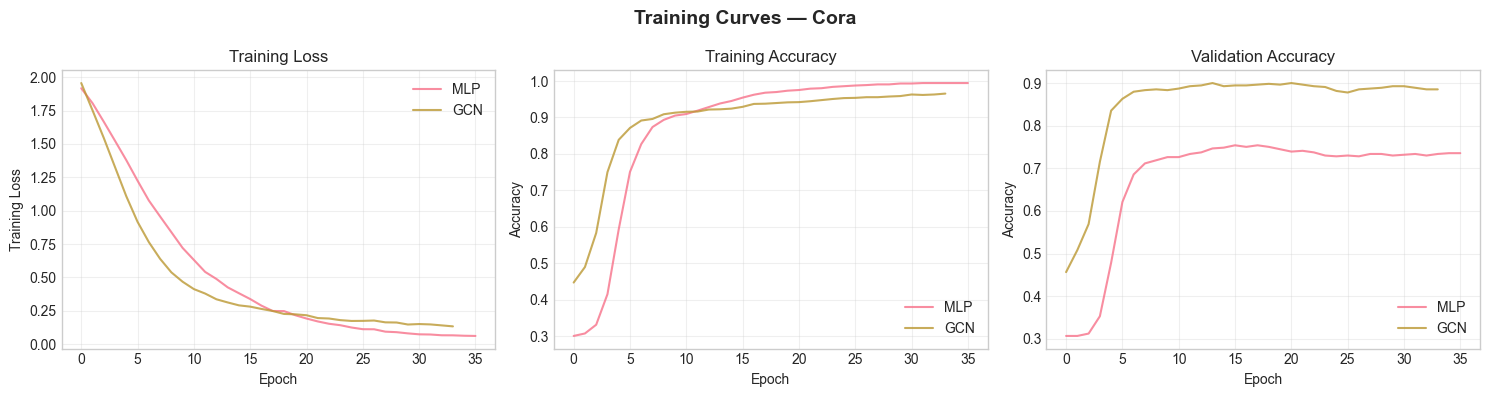

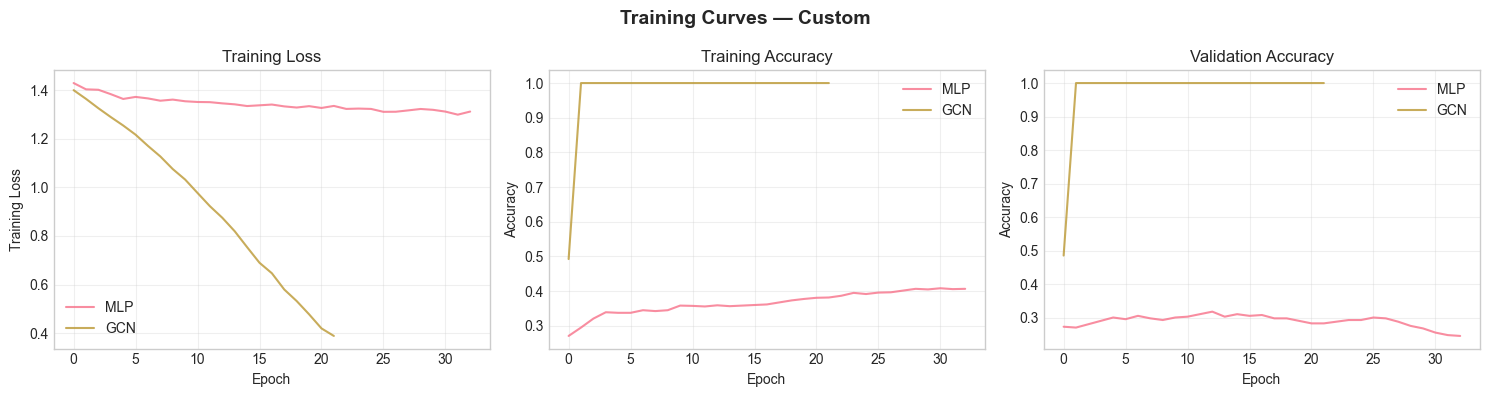

In [25]:
# Experiment: Weight Decay
weight_decays = [0, 1e-4, 5e-4]
sweep_wd, trainers_wd = run_hyperparam_sweep('weight_decay', weight_decays, base_config, datasets_exp, exp_masks)
plot_hyperparam_sweep(sweep_wd, 'weight_decay', weight_decays,
                      'Impacto de la Regularización L2', 'images/exp_weight_decay.png')

# Summary table
display_sweep_table(sweep_wd, 'weight_decay', 'Weight Decay')

# Training curves for weight_decay = 1e-4
print("\n— Curvas de entrenamiento para weight_decay = 1e-4 —")
trainers_wd[1e-4].plot_training_curves(run = 0, filename = 'images/curves_wd1e4')

**Análisis del weight decay (`weight_decay`):**

`weight_decay` es regularización L2: penaliza pesos grandes para mejorar generalización y estabilidad.

En estos resultados, su efecto también es pequeño:
- En **GCN**, diferencias bajas (Custom **0.9990-1.0000**, Cora **0.8751-0.8832**, Citeseer **0.7604-0.7682**).
- En **MLP**, el mayor cambio aparece en Custom (**0.2590 -> 0.2780**), pero sigue siendo un cambio moderado en términos absolutos.

Early stopping casi no se mueve (rango típico de 1 a 5 epochs entre valores de `weight_decay`). El `weight_decay` no cambia el comportamiento global del modelo.




#### Experimento: Optimizador (Adam vs SGD)

Sweep optimizer_type: 100%|██████████| 2/2 [05:30<00:00, 165.22s/it]


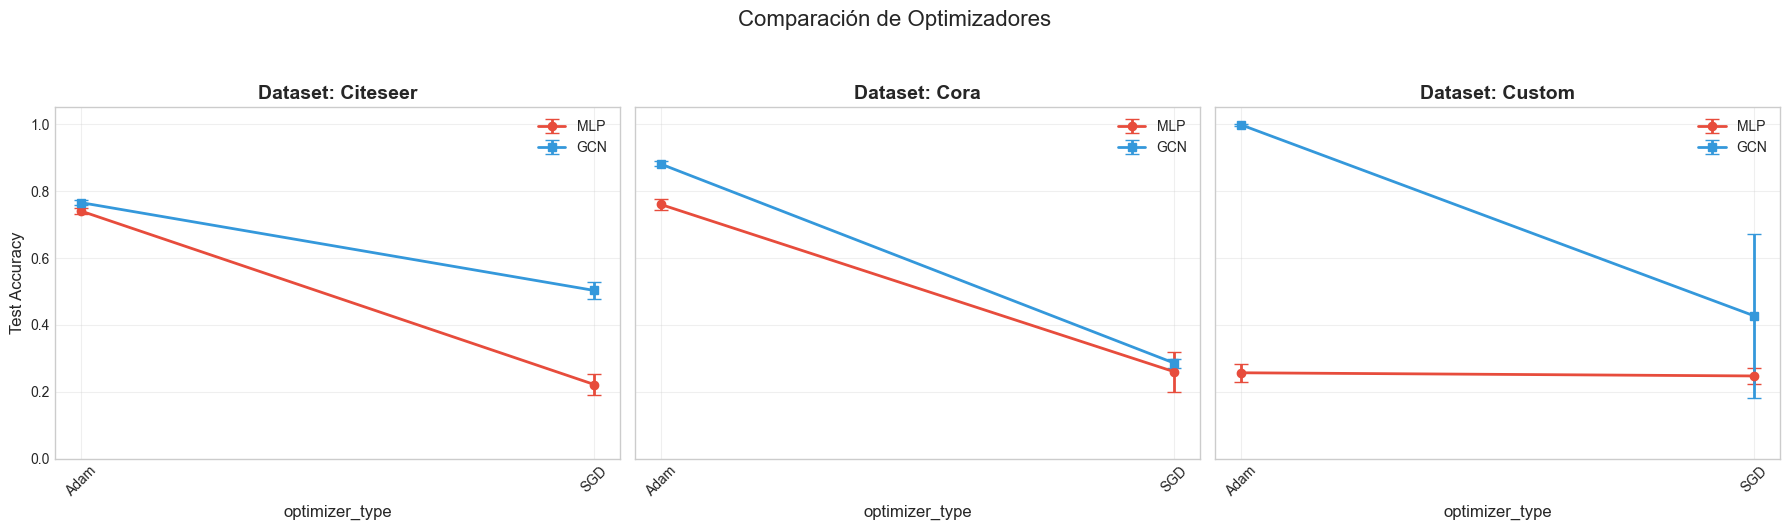

,Optimizer,Dataset,Model,Accuracy,Avg Epochs
0,Adam,Citeseer,GCN,0.7658 ± 0.0065,29
1,Adam,Citeseer,MLP,0.7408 ± 0.0088,30
2,Adam,Cora,GCN,0.8810 ± 0.0074,39
3,Adam,Cora,MLP,0.7602 ± 0.0176,42
4,Adam,Custom,GCN,0.9985 ± 0.0034,23
5,Adam,Custom,MLP,0.2570 ± 0.0268,28
6,SGD,Citeseer,GCN,0.5030 ± 0.0261,200
7,SGD,Citeseer,MLP,0.2219 ± 0.0326,73
8,SGD,Cora,GCN,0.2858 ± 0.0131,76
9,SGD,Cora,MLP,0.2600 ± 0.0604,68



— Curvas de entrenamiento para optimizer = SGD —


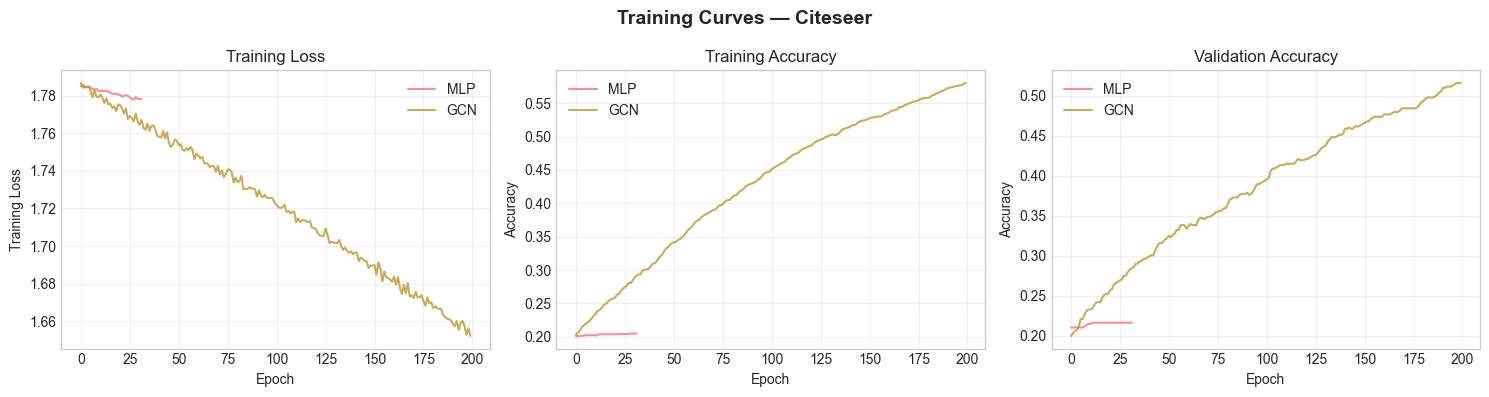

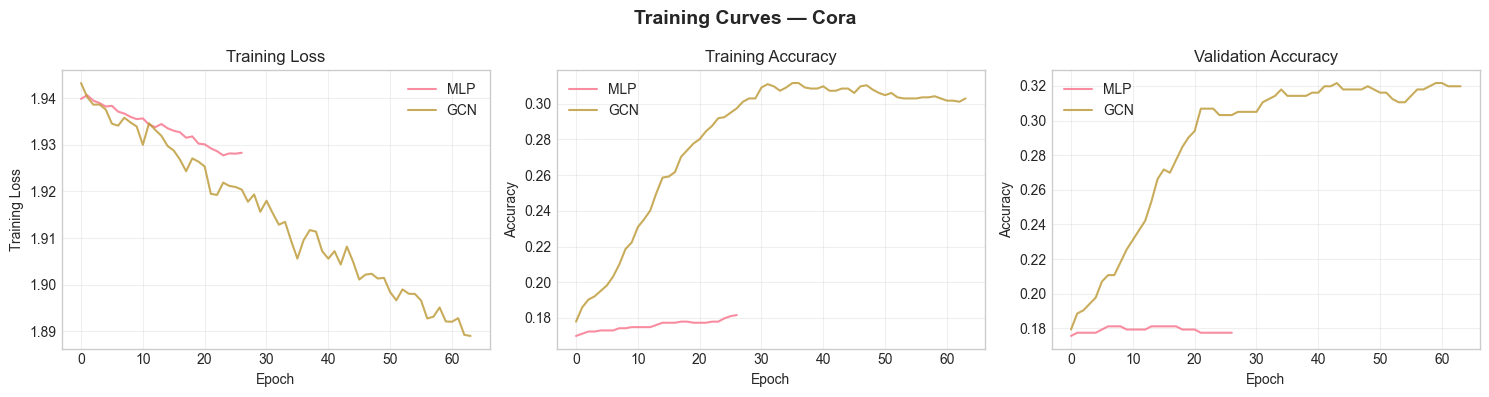

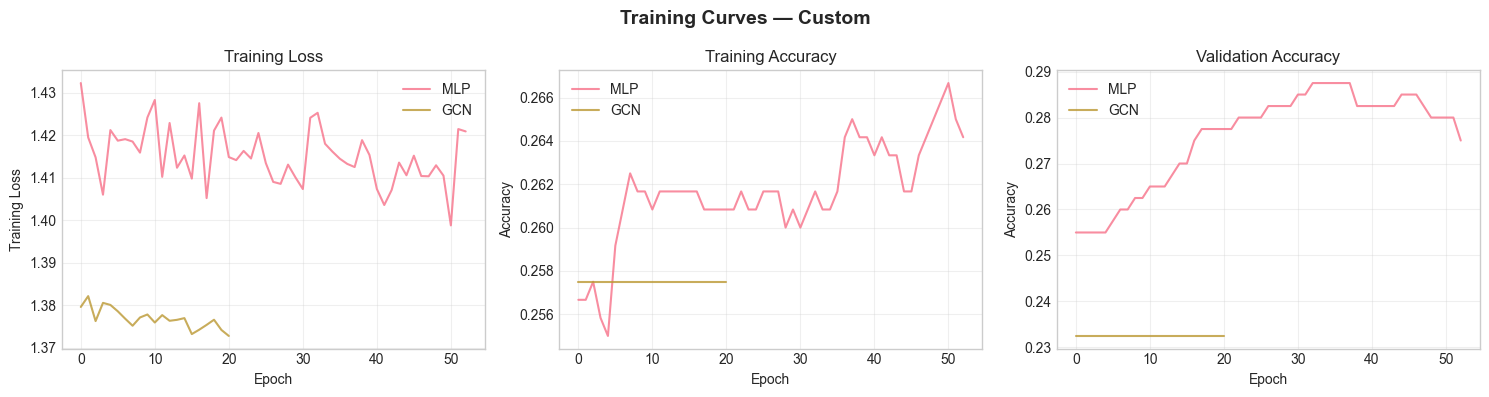

In [26]:
# Experiment: Optimizer
optimizers = ['Adam', 'SGD']
sweep_opt, trainers_opt = run_hyperparam_sweep('optimizer_type', optimizers, base_config, datasets_exp, exp_masks)
plot_hyperparam_sweep(sweep_opt, 'optimizer_type', optimizers,
                      'Comparación de Optimizadores', 'images/exp_optimizer.png')

# Summary table
display_sweep_table(sweep_opt, 'optimizer_type', 'Optimizer')

# Training curves for SGD
print("\n— Curvas de entrenamiento para optimizer = SGD —")
trainers_opt['SGD'].plot_training_curves(run = 0, filename = 'images/curves_sgd')


**Análisis de optimizadores (`Adam` vs `SGD`):**

El optimizador define **cómo** se actualizan los pesos.
- `SGD`: paso fijo para todos los parámetros.
- `Adam`: paso adaptativo por parámetro (normalmente converge más rápido y estable).

Aquí está el cambio grande de verdad:
- **GCN-Cora**: `Adam 0.8810` vs `SGD 0.2858`
- **GCN-Custom**: `Adam 0.9985` vs `SGD 0.4270`
- **MLP-Cora**: `Adam 0.7602` vs `SGD 0.2600`
- **MLP-Citeseer**: `Adam 0.7408` vs `SGD 0.2219`

Solo en **MLP-Custom** son parecidos (`0.2570` vs `0.2475`) porque ambos ya están en un régimen de rendimiento muy bajo y parecido.

¿Por qué pasa esto? En tu setup (mismo `lr=0.01`, sin momentum en SGD, pocas epochs efectivas por early stopping), SGD se queda corto en varios casos: converge lento o queda en zonas malas. Adam, al adaptar la tasa por parámetro, encaja mejor con features ruidosas.


#### Tabla resumen de todos los experimentos

In [27]:
# Consolidate all hyperparameter sweep results into one summary table
all_sweeps = []
all_sweeps_raw = []

for name, df, param_col in [
    ('Hidden Dims', sweep_hidden, 'hidden_channels'),
    ('Learning Rate', sweep_lr, 'lr'),
    ('Dropout', sweep_dropout, 'dropout'),
    ('Weight Decay', sweep_wd, 'weight_decay'),
    ('Optimizer', sweep_opt, 'optimizer_type'),
]:
    df_copy = df.copy()
    df_copy['Experiment'] = name
    df_copy['Param Value'] = df_copy[param_col].astype(str)
    df_copy['Accuracy'] = df_copy.apply(lambda r: f"{r['mean']:.4f} ± {r['std']:.4f}", axis = 1)
    df_copy['Avg Epochs'] = df_copy['avg_epochs'].apply(lambda x: f"{x:.0f}")

    all_sweeps.append(df_copy[['Experiment', 'Param Value', 'Dataset', 'Model', 'Accuracy', 'Avg Epochs']])
    all_sweeps_raw.append(df_copy[['Experiment', 'Param Value', 'Dataset', 'Model', 'mean', 'avg_epochs']])

summary_all = pd.concat(all_sweeps, ignore_index = True)
summary_all_raw = pd.concat(all_sweeps_raw, ignore_index = True)

display(summary_all)

# How much each hyperparameter actually changes final accuracy
impact_by_experiment = (
    summary_all_raw
    .groupby(['Experiment', 'Dataset', 'Model'])['mean']
    .agg(['min', 'max'])
    .reset_index()
)
impact_by_experiment['Delta Accuracy'] = (impact_by_experiment['max'] - impact_by_experiment['min']).round(4)
impact_by_experiment = impact_by_experiment[['Experiment', 'Dataset', 'Model', 'Delta Accuracy']]
impact_by_experiment = impact_by_experiment.sort_values('Delta Accuracy', ascending = False)

display(impact_by_experiment)

# Where early stopping takes longest (largest avg epochs)
early_stop_hotspots = summary_all_raw.copy()
early_stop_hotspots = early_stop_hotspots.sort_values('avg_epochs', ascending = False).head(12)
early_stop_hotspots['Mean Test Acc'] = early_stop_hotspots['mean'].round(4)
early_stop_hotspots['Avg Epochs'] = early_stop_hotspots['avg_epochs'].round(0).astype(int)
early_stop_hotspots = early_stop_hotspots[['Experiment', 'Param Value', 'Dataset', 'Model', 'Mean Test Acc', 'Avg Epochs']]

display(early_stop_hotspots)

# Quick inventory of generated plots for the hyperparameter section
import glob
sweep_images = sorted(glob.glob('images/exp_*.png'))
curve_images = sorted(glob.glob('images/curves_*.png'))

display(pd.DataFrame({'Sweep Images': sweep_images}))
display(pd.DataFrame({'Curve Images': curve_images}))


,Experiment,Param Value,Dataset,Model,Accuracy,Avg Epochs
0,Hidden Dims,16,Citeseer,GCN,0.7718 ± 0.0169,34
1,Hidden Dims,16,Citeseer,MLP,0.7267 ± 0.0115,36
2,Hidden Dims,16,Cora,GCN,0.8803 ± 0.0073,54
3,Hidden Dims,16,Cora,MLP,0.7359 ± 0.0180,65
4,Hidden Dims,16,Custom,GCN,0.9975 ± 0.0025,29
...,...,...,...,...,...,...
85,Optimizer,SGD,Citeseer,MLP,0.2219 ± 0.0326,73
86,Optimizer,SGD,Cora,GCN,0.2858 ± 0.0131,76
87,Optimizer,SGD,Cora,MLP,0.2600 ± 0.0604,68
88,Optimizer,SGD,Custom,GCN,0.4270 ± 0.2458,61


### Discusión final y conclusiones

**Comparación MLP vs GCN (lo que se ve en tus tablas):**
La GCN gana de forma clara en los 3 datasets porque usa la estructura del grafo. En el dataset Custom (features débiles + comunidades fuertes), la diferencia es extrema: la GCN llega ~1.0 y el MLP se queda alrededor de ~0.26-0.28. En Cora y Citeseer también mejora de forma consistente.

**Sobre la exploración de hiperparámetros (idea clave):**
Tus resultados confirman lo que comentabas: **casi todo cambia poco**, excepto el optimizador. Hidden dims, dropout y weight decay mueven poco la accuracy final; learning rate mueve más el tiempo de convergencia que la accuracy.

**Por qué solo el optimizador cambia mucho:**
Con la misma arquitectura y mismos datos, Adam sí consigue optimizar bien en el presupuesto de entrenamiento, mientras que SGD (sin momentum y con `lr=0.01` fijo) se queda corto en varios escenarios. Por eso ves caídas tan grandes con SGD en Cora/Citeseer y en GCN-Custom. No es que el modelo “deje de servir”, es que el proceso de optimización no llega a buen punto dentro del mismo presupuesto.

**¿Dónde está parando más el early stopping?**
El caso más extremo es **SGD + GCN en Citeseer**, que llega al máximo de **200 epochs** (prácticamente no se activa parada temprana antes del límite). Después destacan **lr=0.001 en Cora**: **MLP ~119 epochs** y **GCN ~102 epochs**. En configuraciones estables con Adam, lo normal es parar mucho antes (aprox. **22-42 epochs**).

**Dónde están las curvas e imágenes de esta parte:**
- Barridos: `images/exp_hidden_dims.png`, `images/exp_learning_rate.png`, `images/exp_dropout.png`, `images/exp_weight_decay.png`, `images/exp_optimizer.png`
- Curvas por configuración elegida: `images/curves_hidden128_*.png`, `images/curves_lr001_*.png`, `images/curves_dropout03_*.png`, `images/curves_wd1e4_*.png`, `images/curves_sgd_*.png`
